This notebook was ran on cent7d.slac.standord.edu
The command to run jupyter is:
```
source /gpfs/slac/lsst/fs2/u1/dh/software/centos7-gcc48/prod/release/setup.sh

jupyter notebook
```

In this notebook, we explored images taken during Run 5 period (2021/11), especially focusing on optimization of sequencer files. We investigated the impact from changing readout time, by looking at readout noise and CTIs.

In [1]:
%matplotlib inline
import numpy as np
from get_EO_analysis_results import get_EO_analysis_results
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import scipy.stats as stats

from astropy.table import Table
import pylab
import numpy

raft_types = {}
raft_types['e2v'] = 'R11 R12 R13 R14 R21 R22 R23 R24 R30 R31 R32 R33 R34'.split()
raft_types['ITL'] = 'R01 R02 R03 R10 R20 R41 R42 R43'.split()
raft_types['Corner'] = 'R00 R04 R40 R44'.split()

EO = get_EO_analysis_results(db='Prod')


In [2]:
dev_list1, data1 = EO.get_tests(site_type='I&T-BOT', run=13040)
botresults1 = EO.get_all_results(data1)

In [3]:
def makescatter( botrun1, botrun2, aresult, bresult, akey, lim, suptitle="", scale=1., err=True ):
    errkey = akey+"_error"
    fig, axs = pylab.subplots(1,2,figsize=(10,5),dpi=150,facecolor="white")
    data = { }
    for atype in raft_types:
        data[atype] = { "x":[], "y": [], "xerr": [], "yerr": [] }
        for abay in raft_types[atype]:
            for asensor in aresult[akey][abay]:
                data[atype]["x"].extend(aresult[akey][abay][asensor])
                data[atype]["y"].extend(bresult[akey][abay][asensor])
                try:
                    data[atype]["xerr"].extend(aresult[akey][abay][asensor])
                    data[atype]["yerr"].extend(bresult[akey][abay][asensor])
                except:
                    pass

    for ax in axs:
        for atype in raft_types:
            if err==True:
                extra = {
                    "xerr": data[atype]["xerr"],
                    "yerr": numpy.array(data[atype]["yerr"])*scale
                }
            else:
                extra = {}

            ax.errorbar(
                data[atype]["x"],
                numpy.array(data[atype]["y"])*scale,
                fmt="o", mec="k", label=atype, **extra )

    for ax, (scalemin, scalemax) in zip(axs, lim ):
        x=numpy.arange(scalemin,scalemax*1.01,(scalemax-scalemin)/100)
        params = {"color":"k","alpha":0.5}
        ax.plot(x,x*1.1, ls="--", **params)
        ax.plot(x,x, ls="-", **params)
        ax.plot(x,x*0.9, ls="--", **params)
        ax.legend()
        ax.set_ylim(scalemin,scalemax)
        ax.set_xlim(scalemin,scalemax)
        ax.set_xlabel(botrun1)
        ax.set_ylabel(botrun2)
        ax.set_aspect(1)
        ax.set_title(akey)

    pylab.suptitle(suptitle)
    pylab.tight_layout()
    pylab.show()


# Compare runs that that were changed in RampTime, ISO1 and ISO2

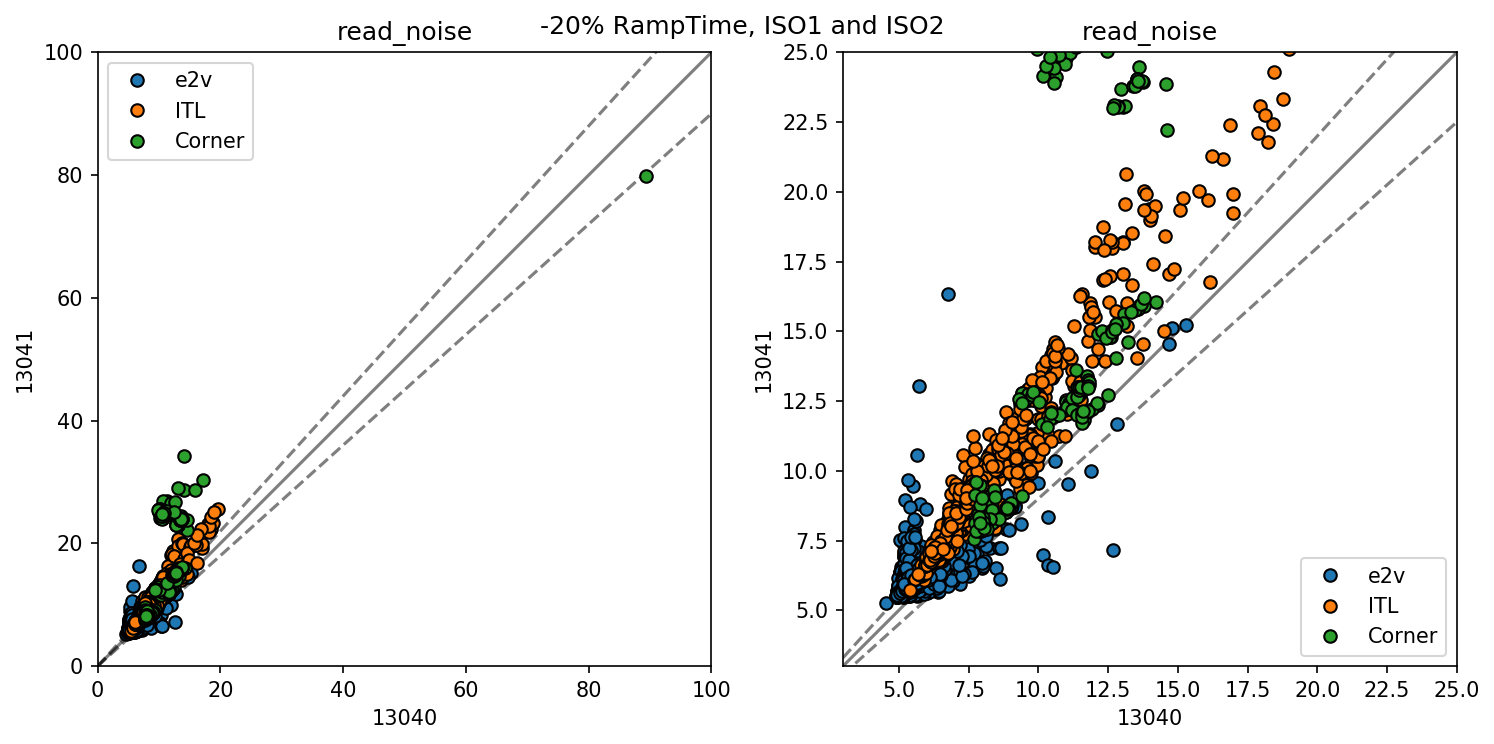

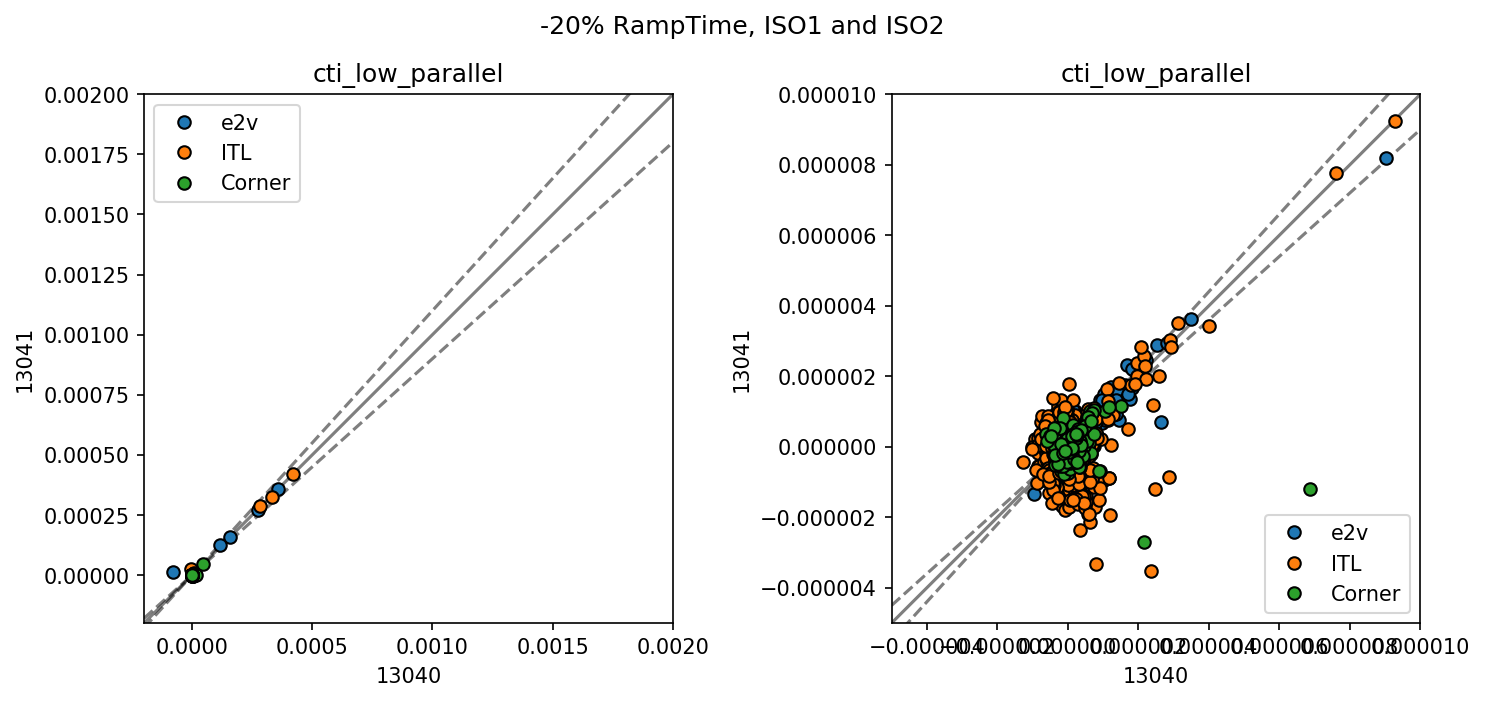

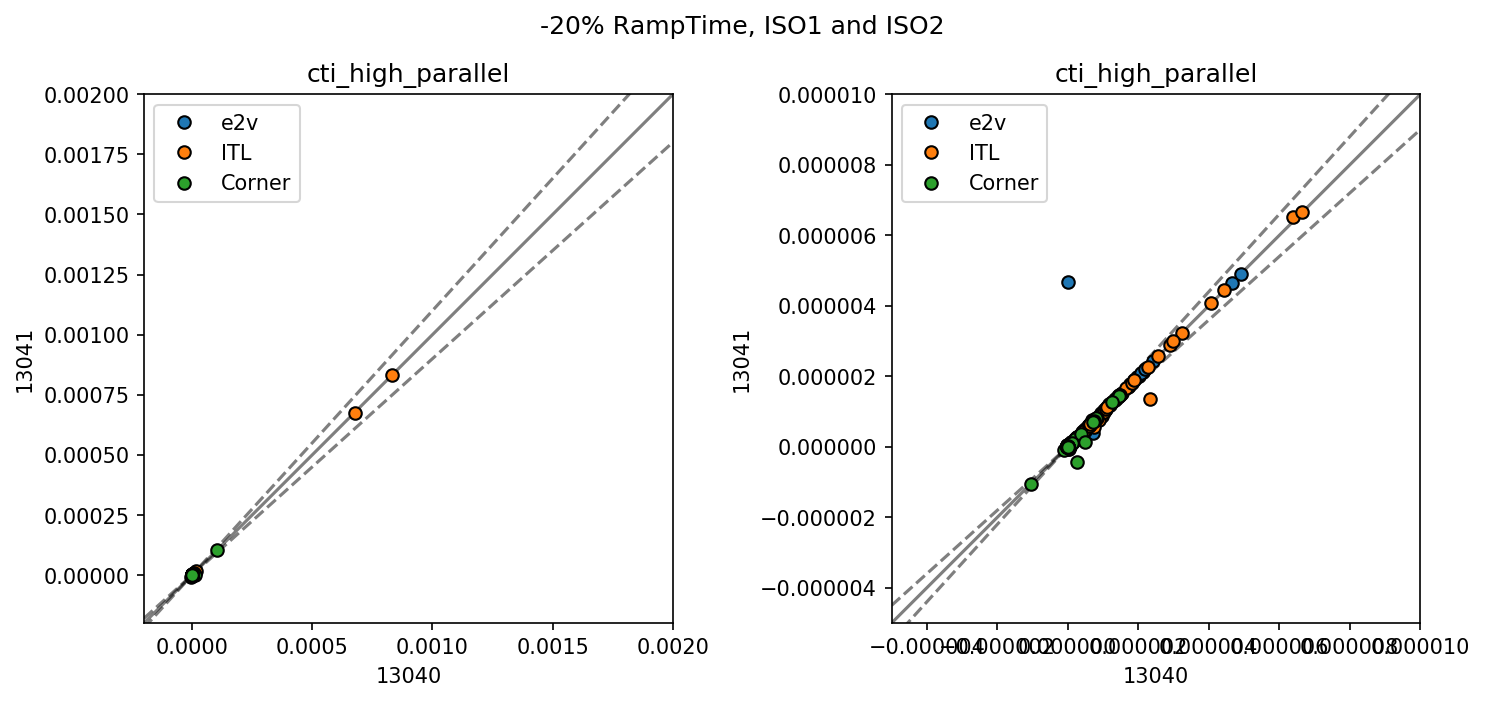

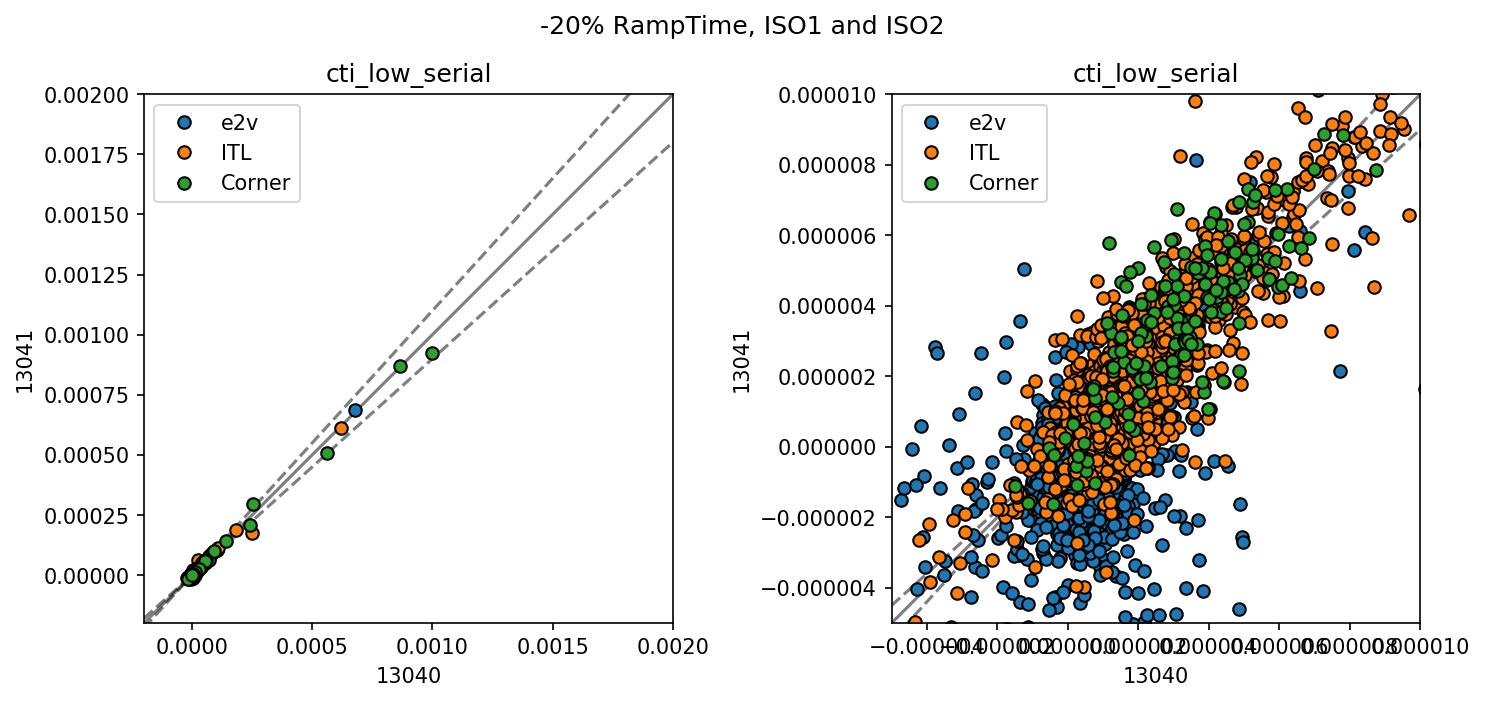

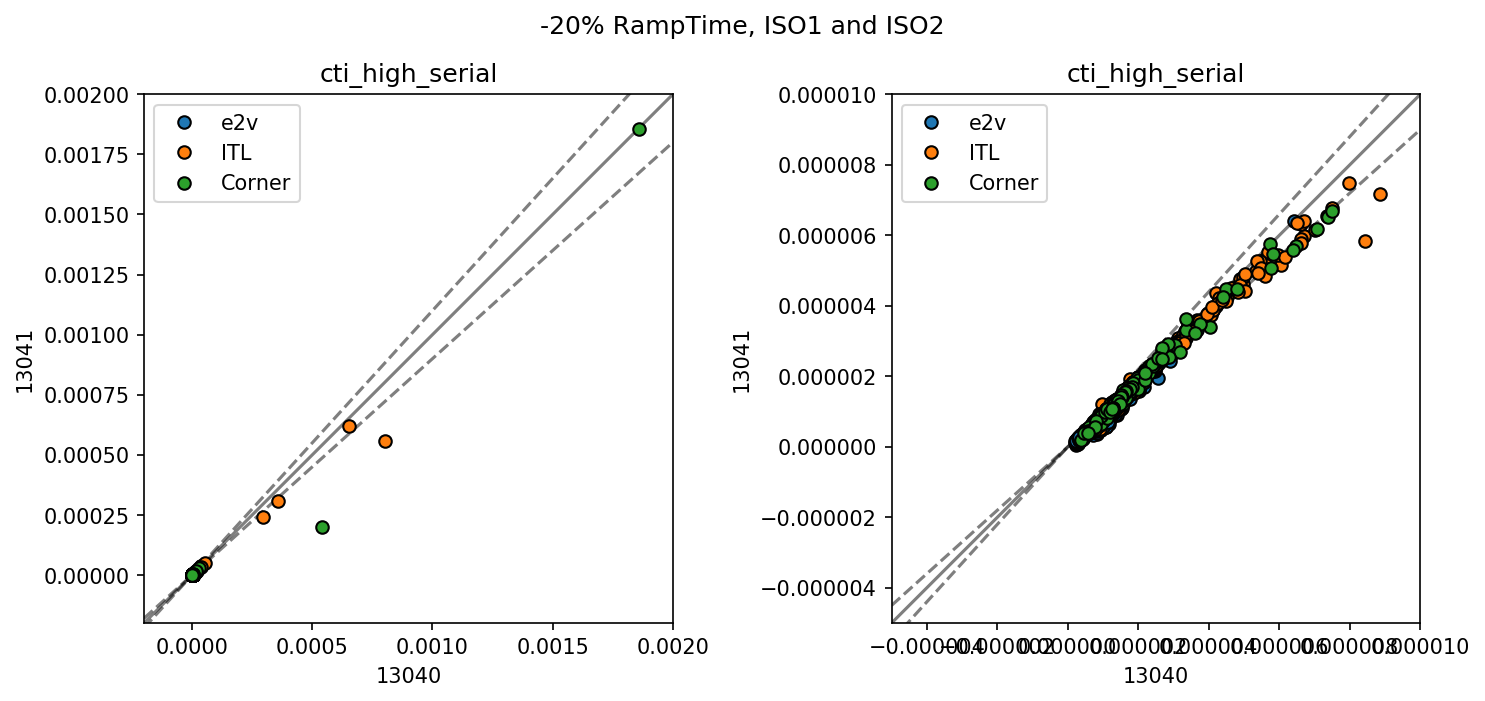

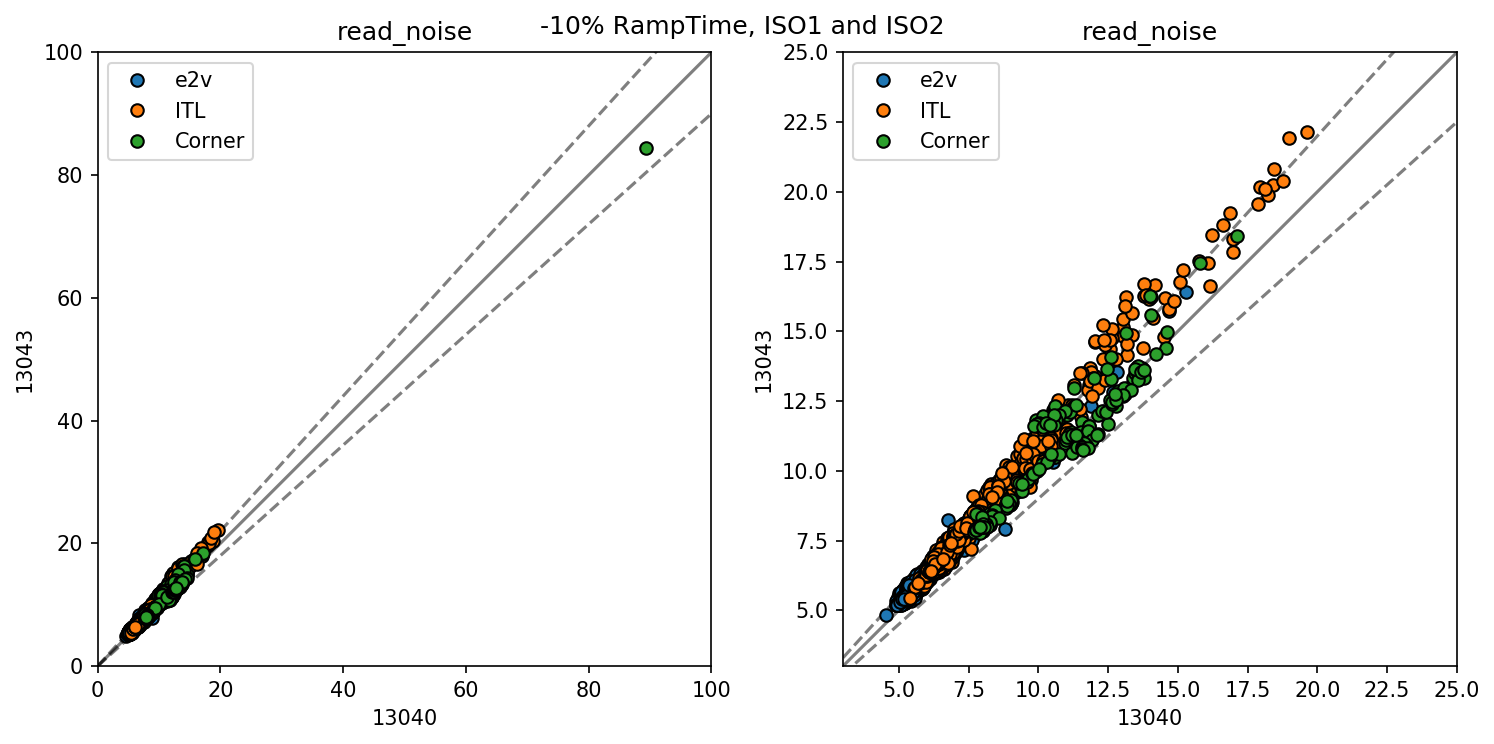

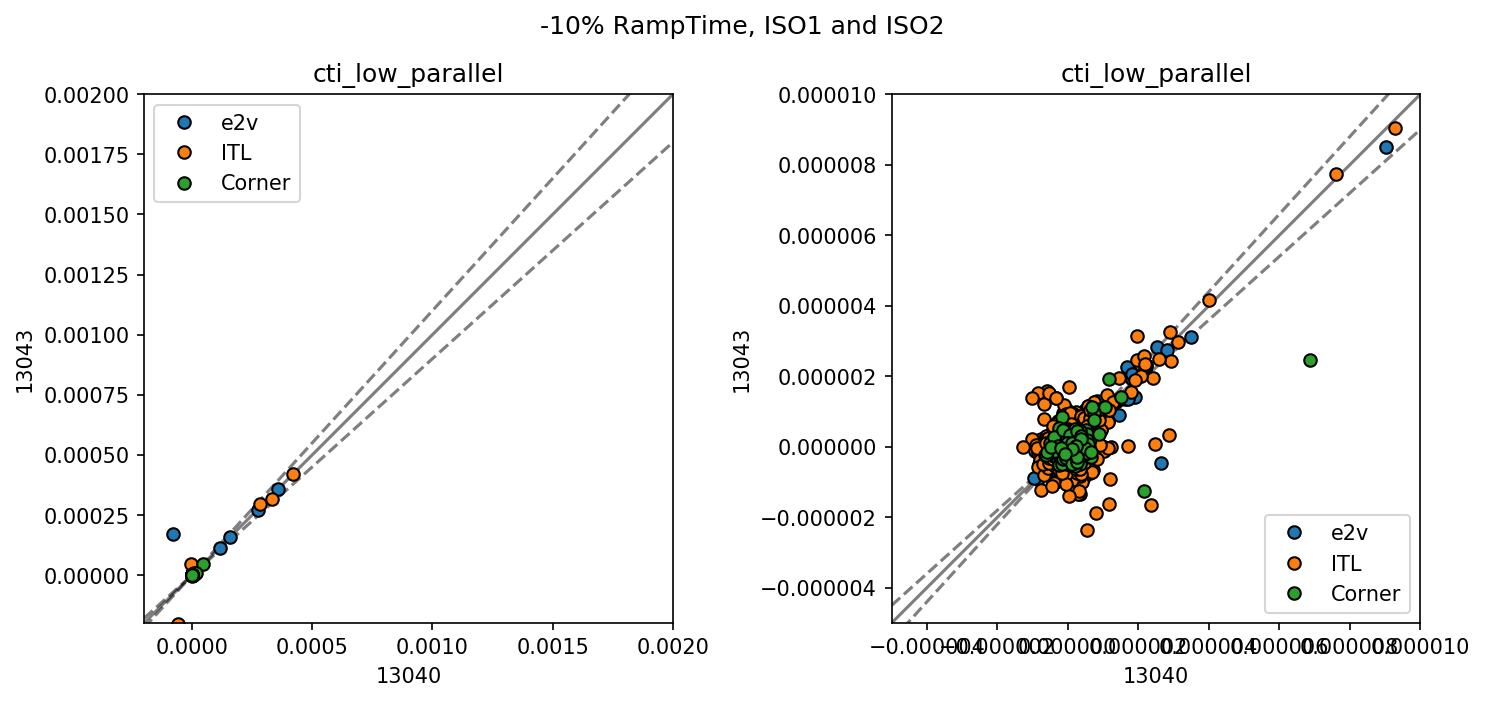

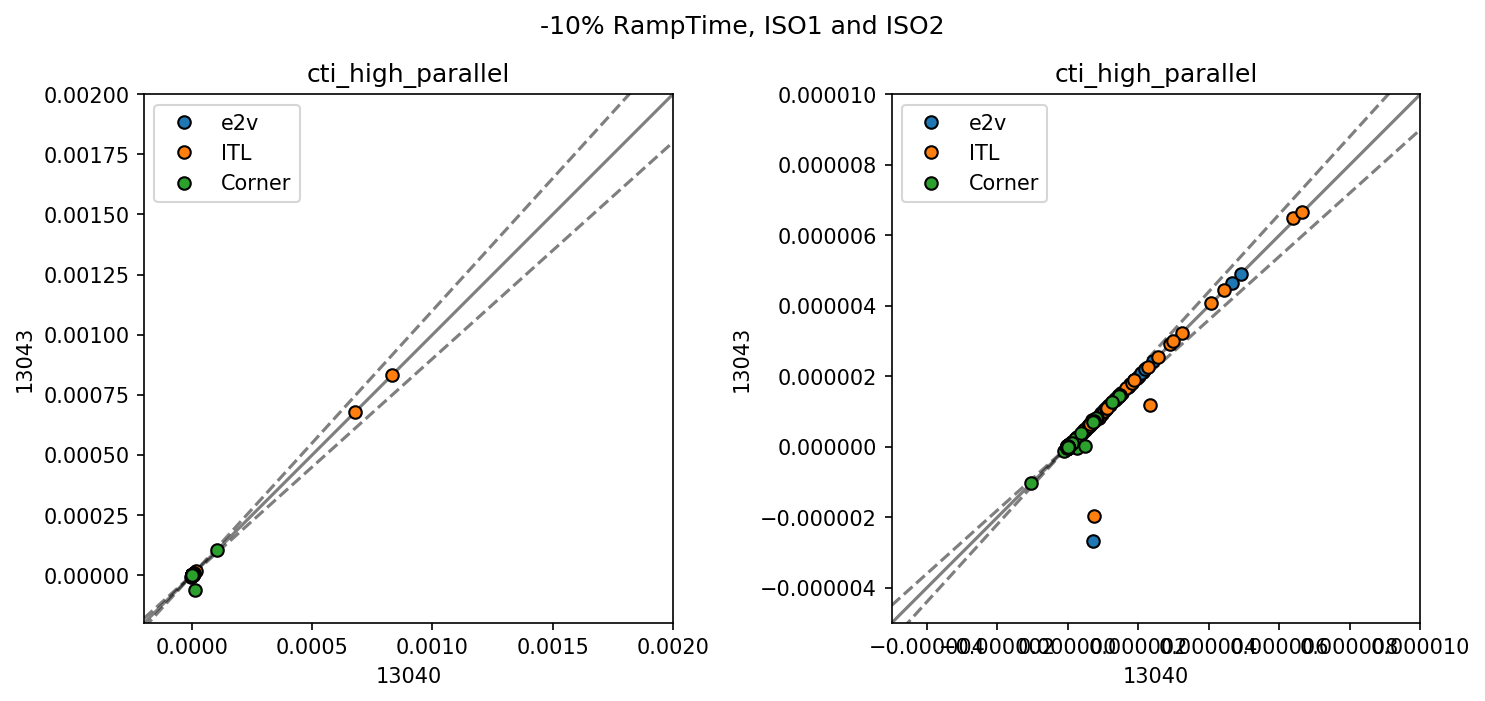

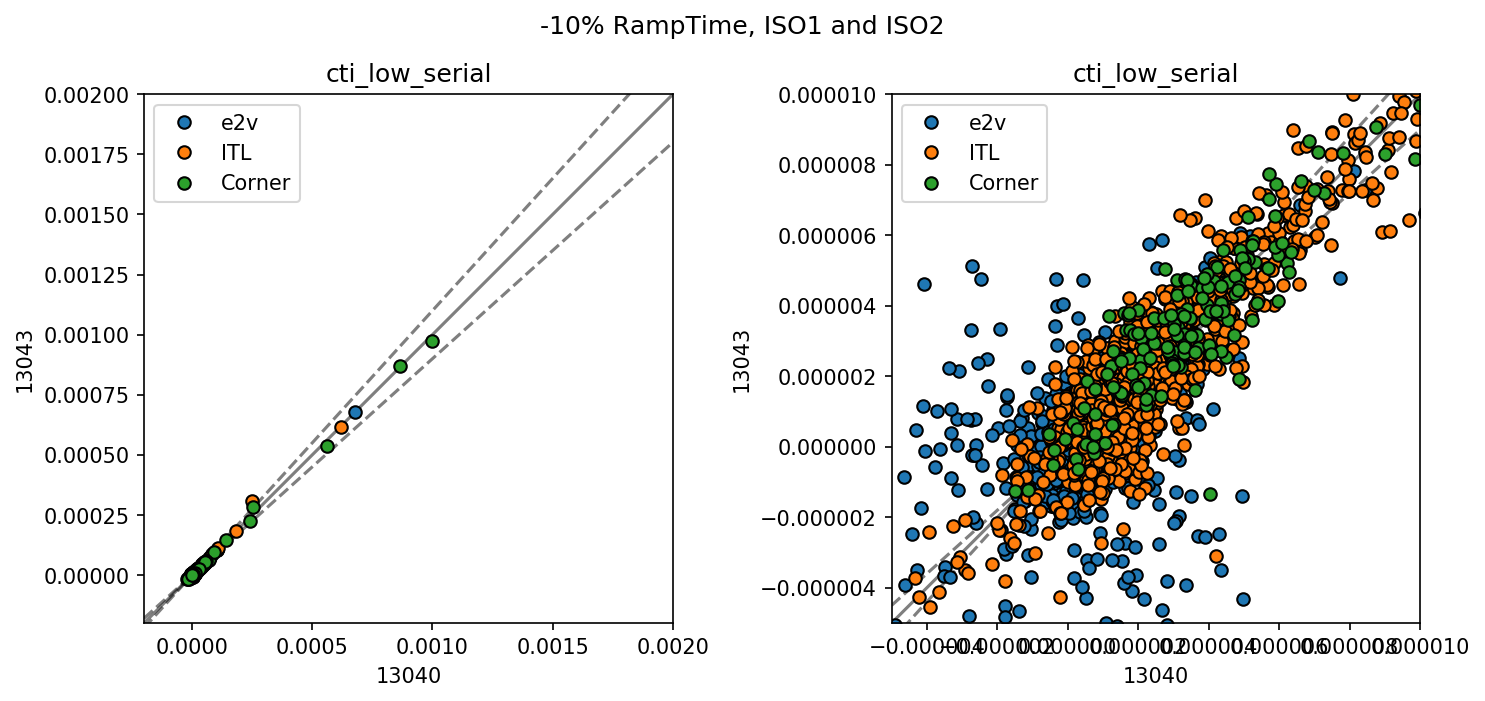

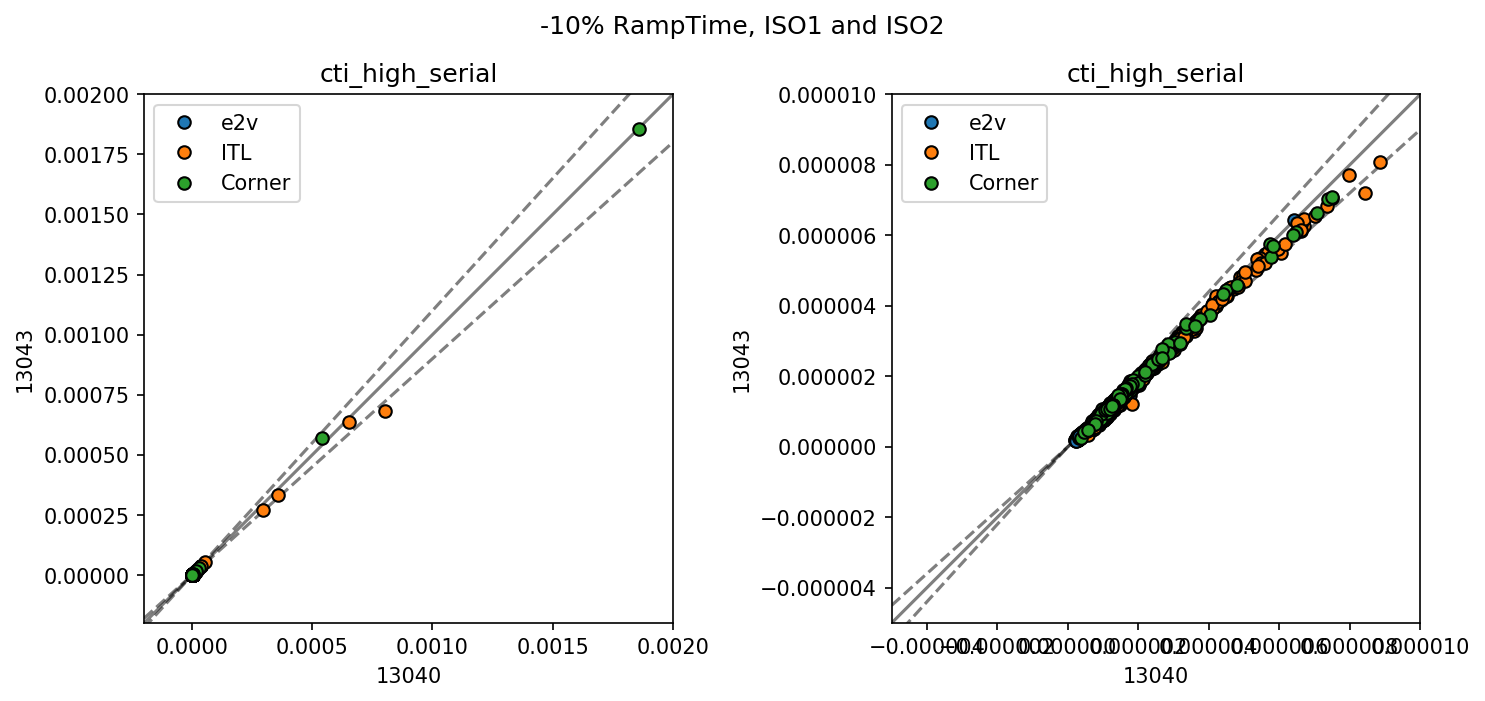

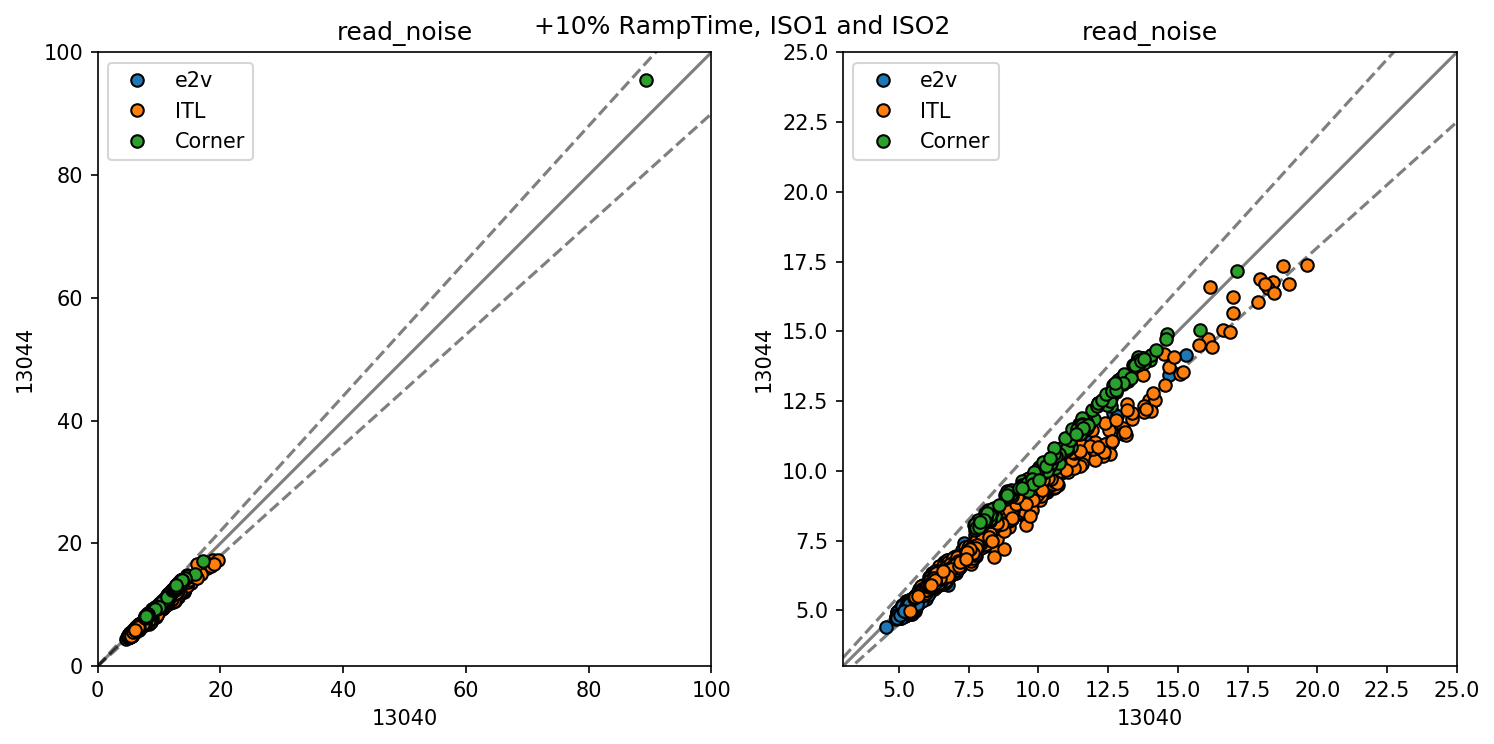

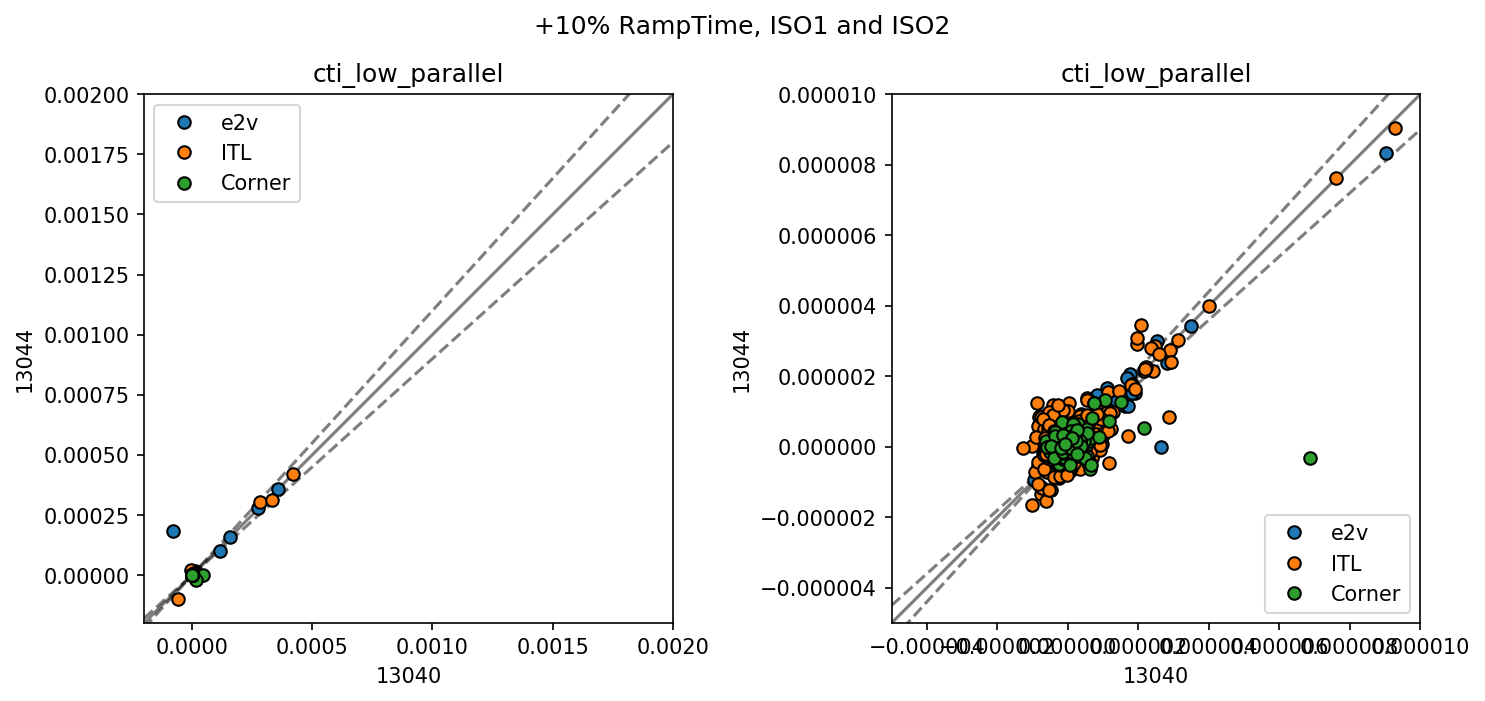

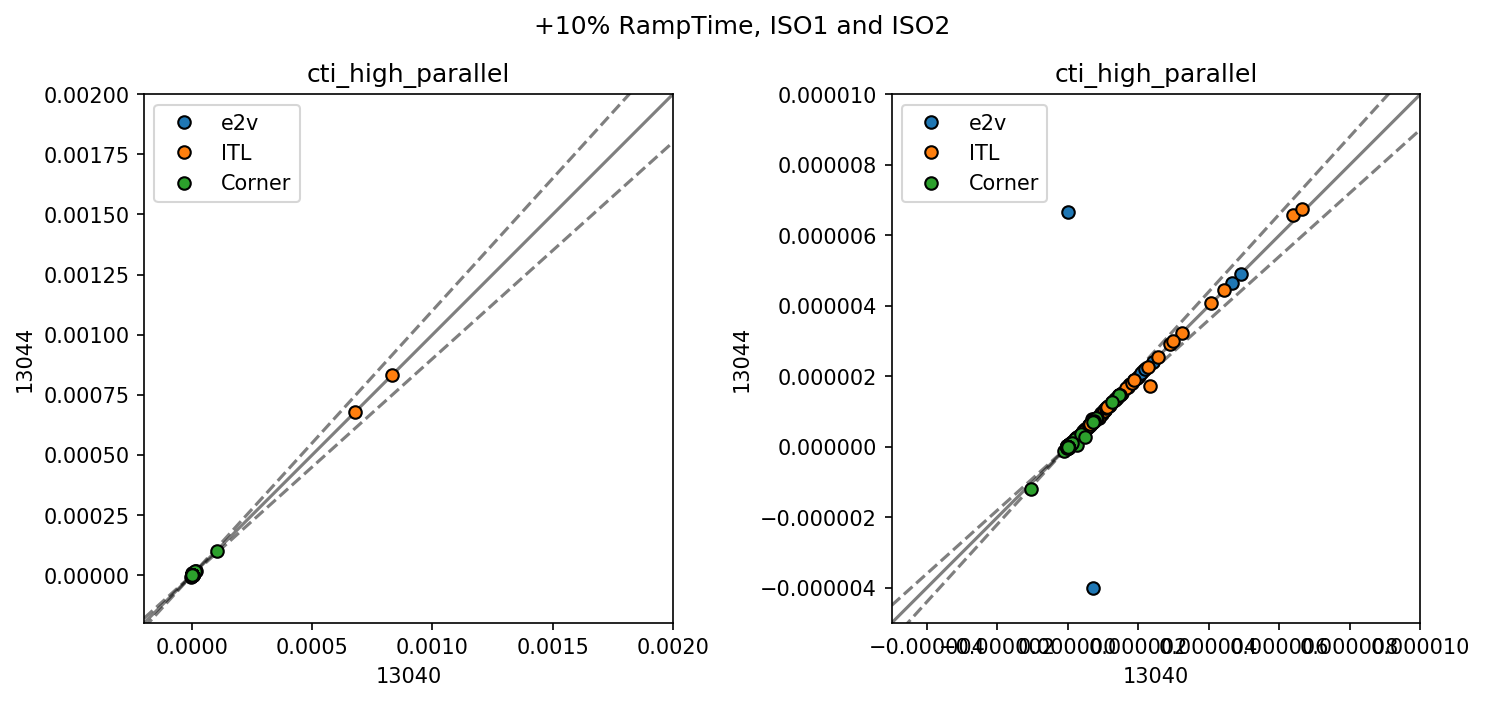

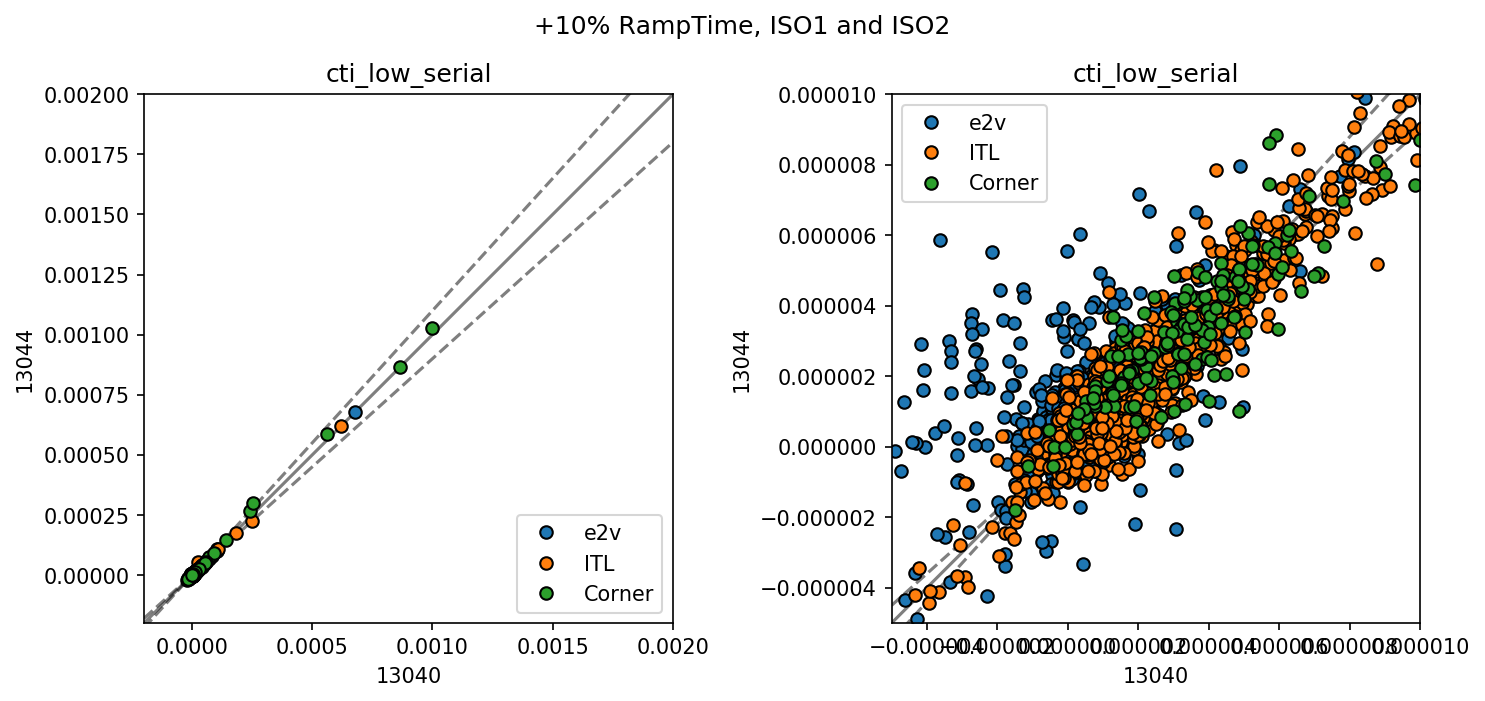

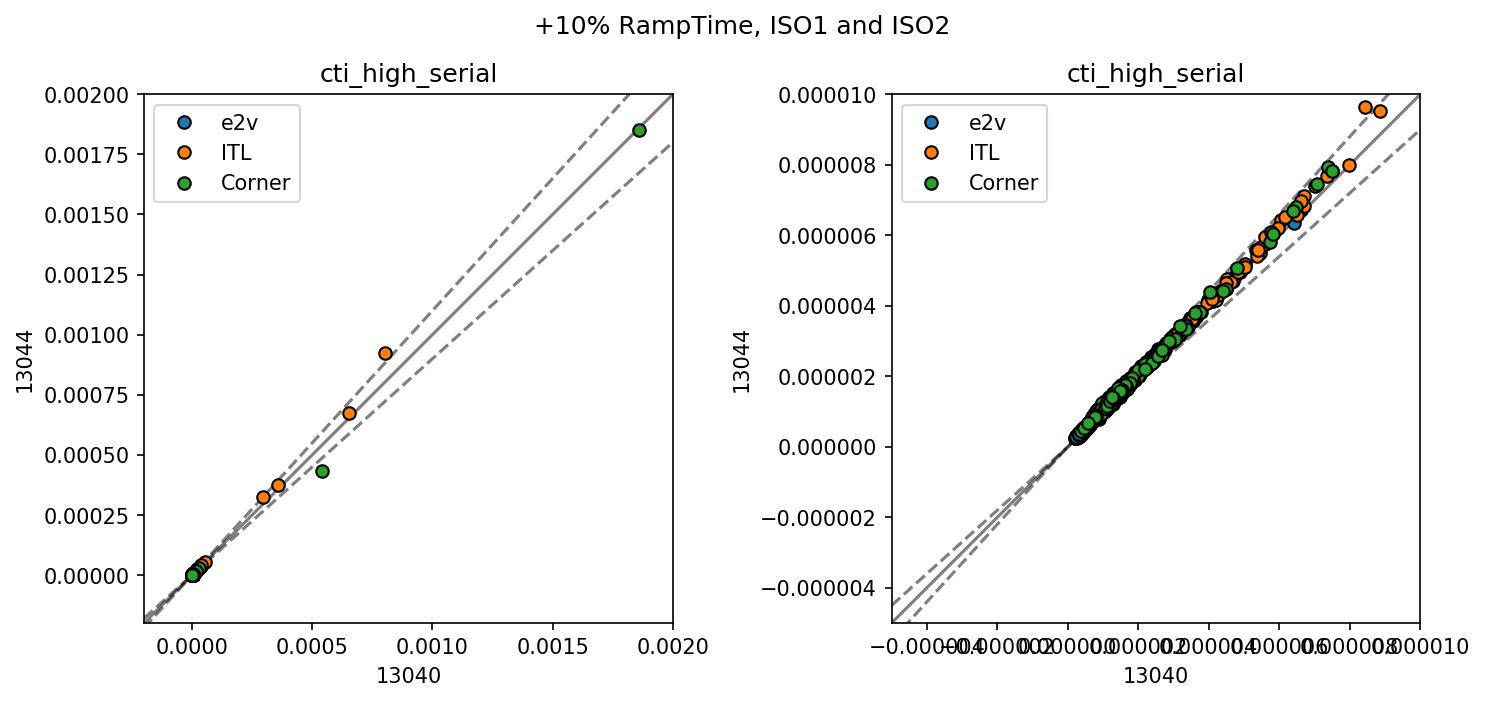

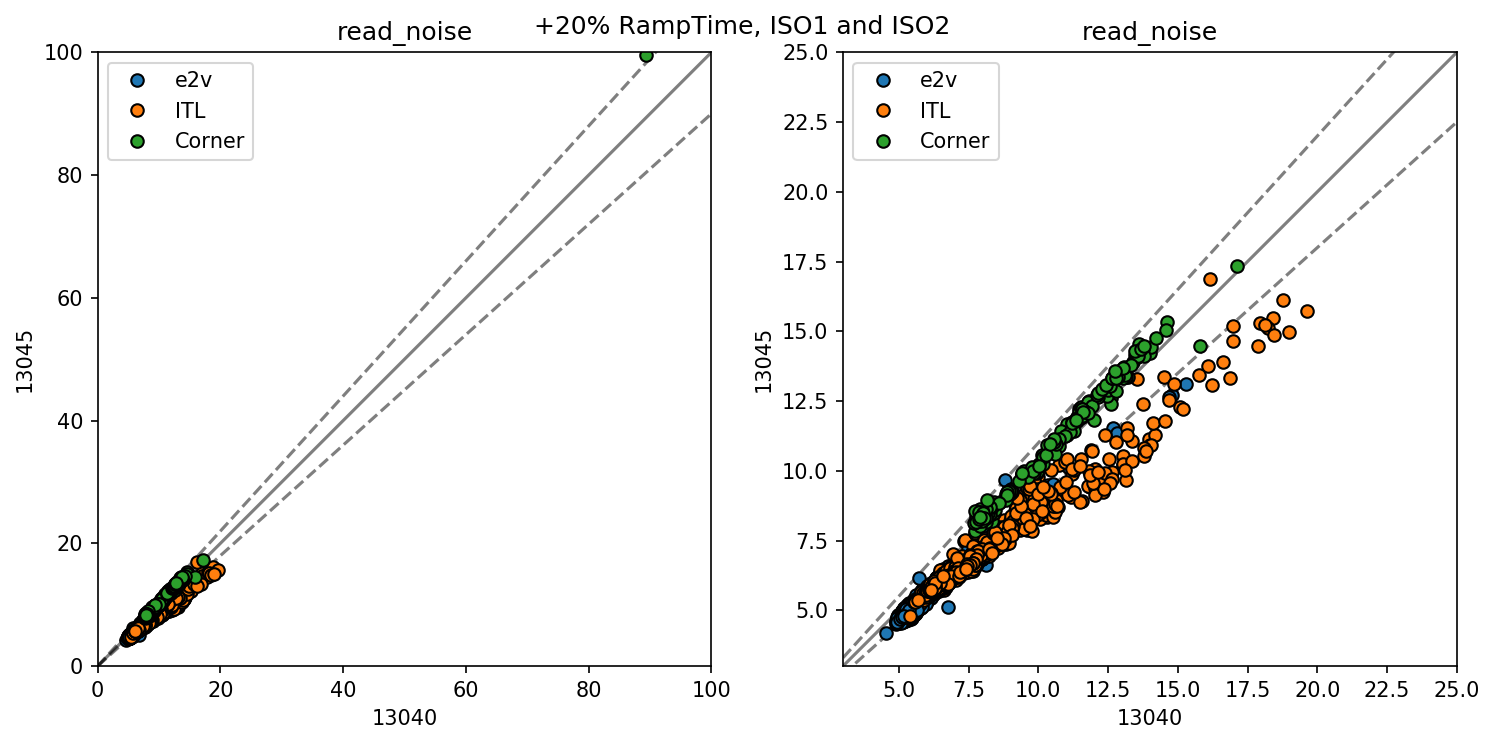

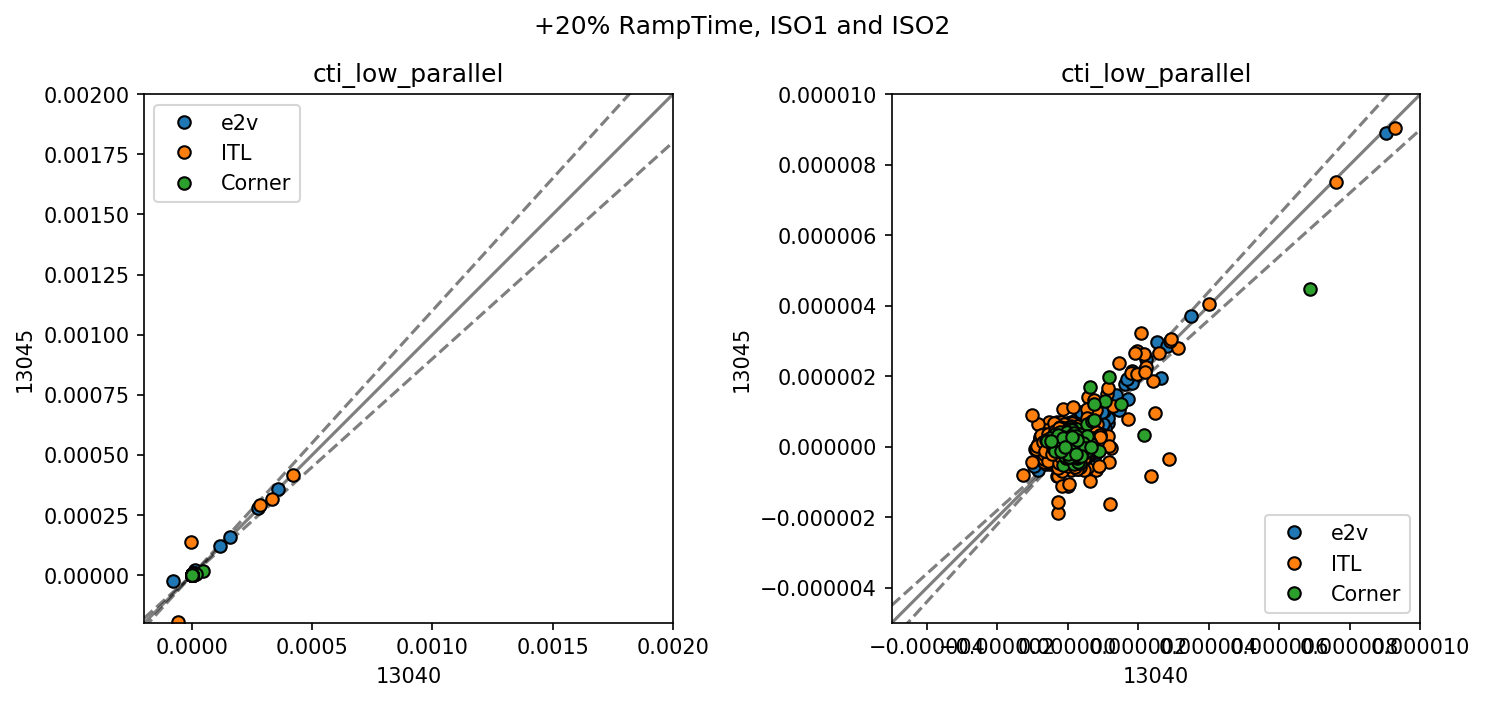

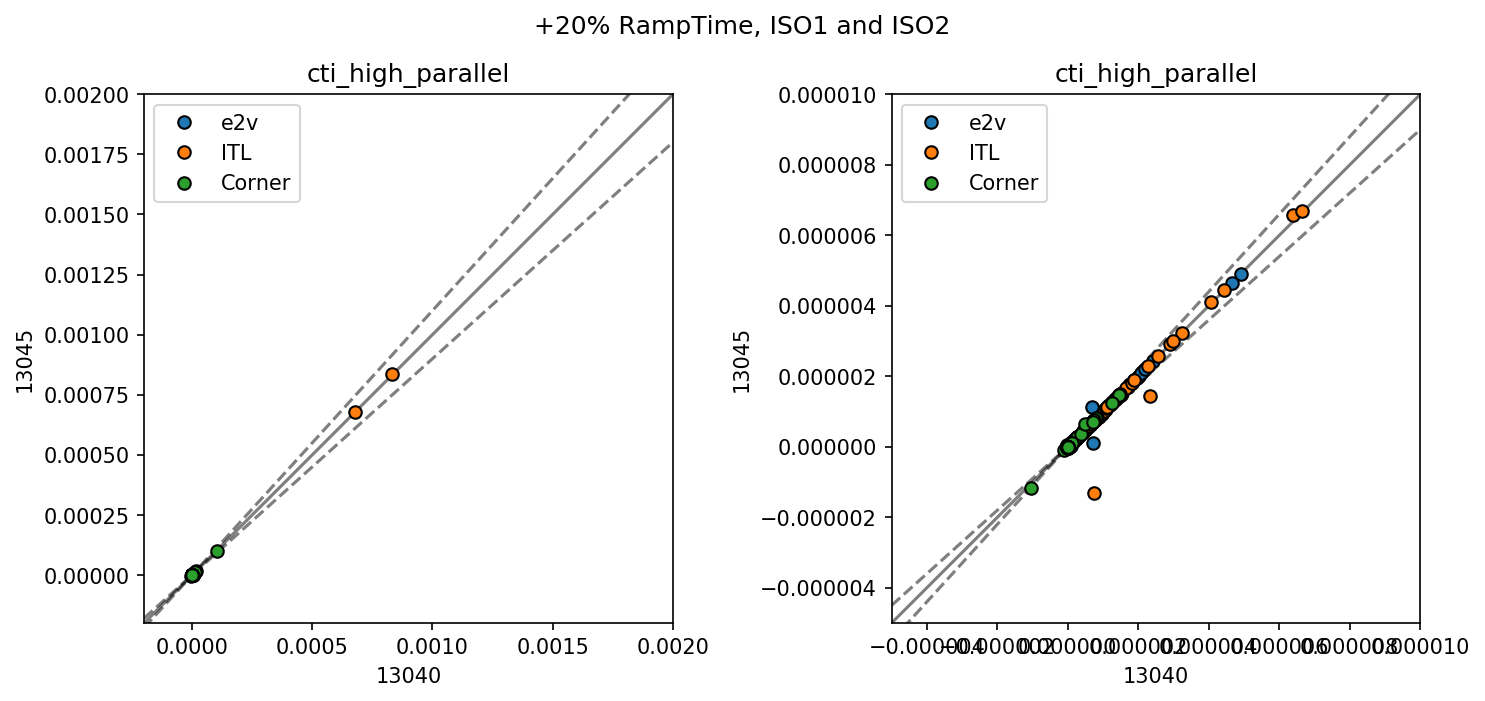

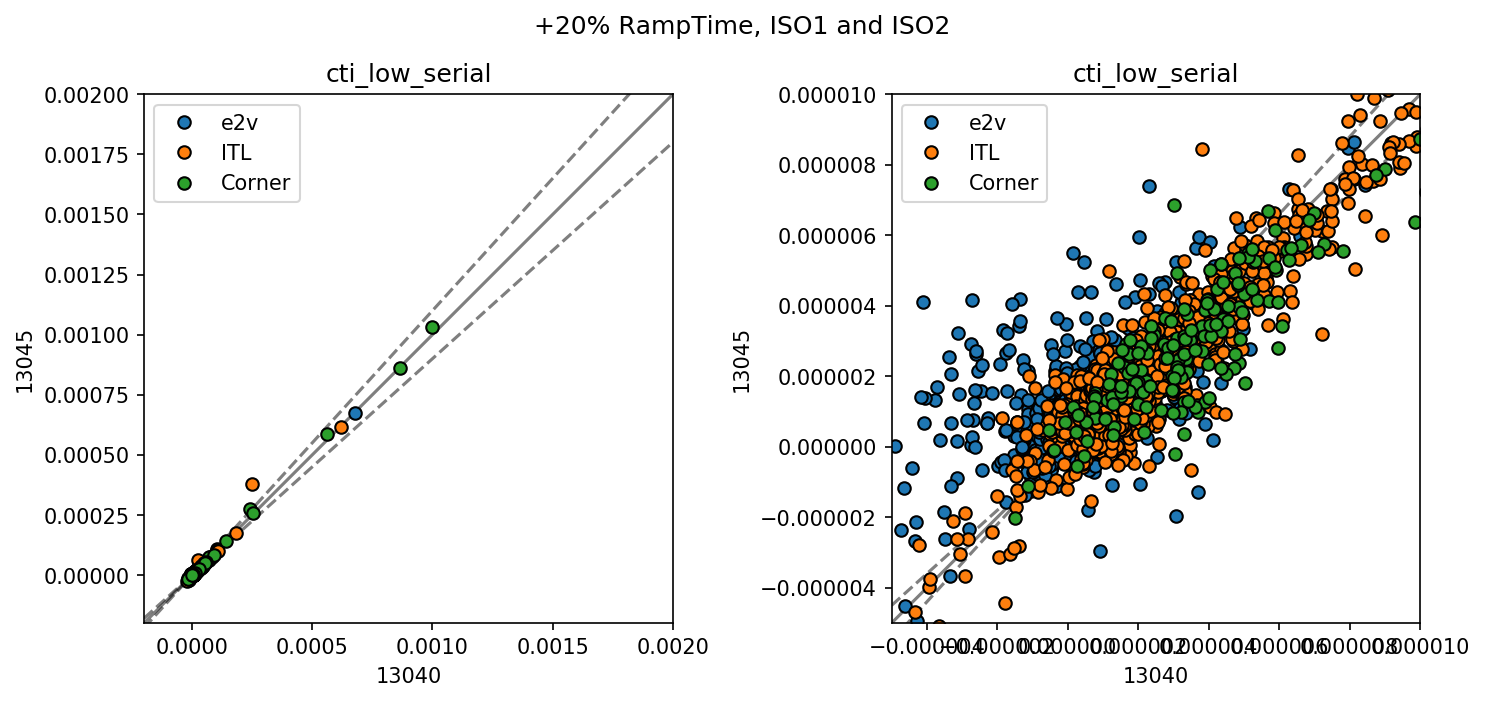

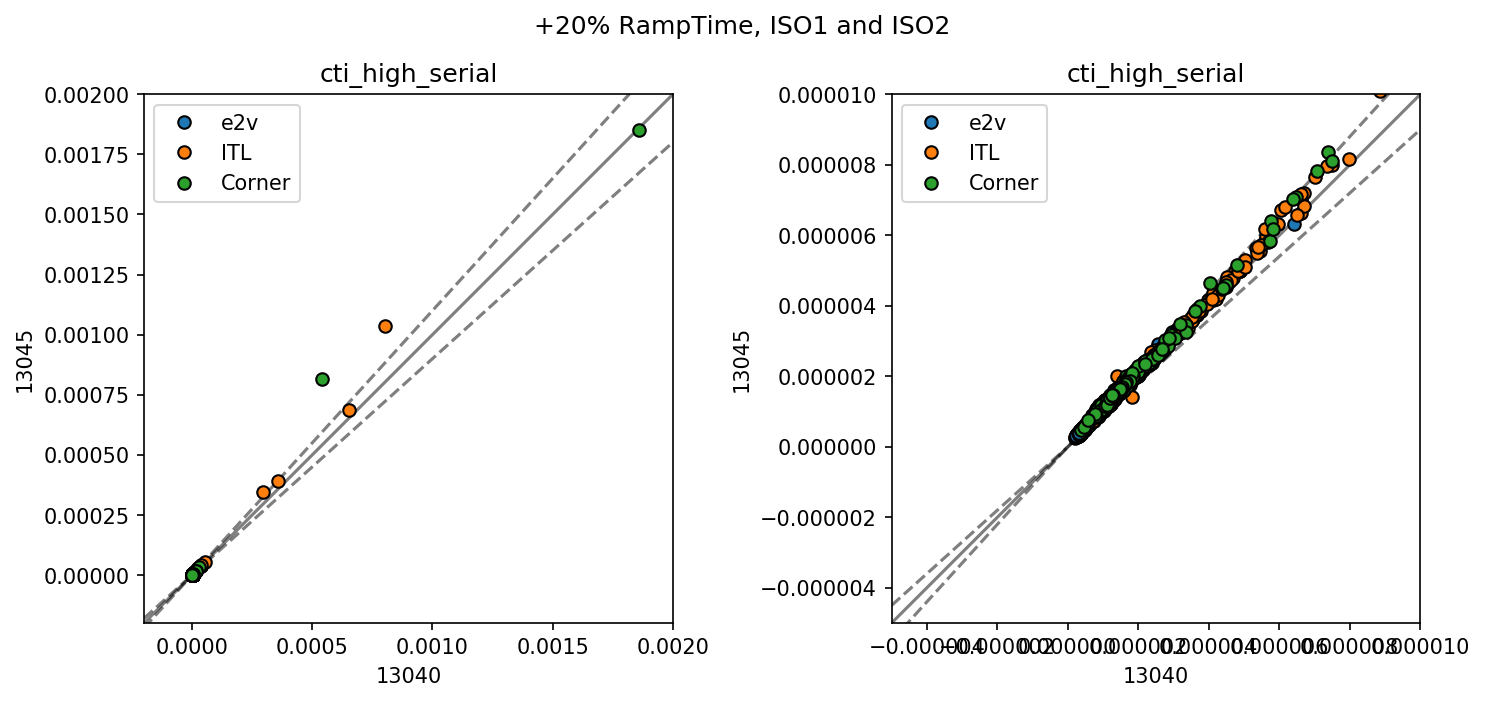

In [4]:
botrun1 = 13040
dev_list1, data1 = EO.get_tests(site_type='I&T-BOT', run=botrun1)
botresults1 = EO.get_all_results(data1)    
    
for botrun2, scale, title in [
    (13041, 1.231, "-20% RampTime, ISO1 and ISO2" ),
    (13043, 1.104, "-10% RampTime, ISO1 and ISO2"),
    (13044, 0.914, "+10% RampTime, ISO1 and ISO2"),
    (13045, 0.8434, "+20% RampTime, ISO1 and ISO2")
    ]:
    dev_list2, data2 = EO.get_tests(site_type='I&T-BOT', run=botrun2)
    botresults2 = EO.get_all_results(data2)
    for atest, lim, s in [
        ("read_noise", [ (0, 100), (3, 25) ], scale ),
        ("cti_low_parallel", [ (-2e-4, 2e-3), (-.5e-5, 1e-5) ], 1),
        ("cti_high_parallel", [ (-2e-4, 2e-3), (-.5e-5, 1e-5) ], 1),
        ("cti_low_serial", [ (-2e-4, 2e-3), (-.5e-5, 1e-5) ], 1),
        ("cti_high_serial", [ (-2e-4, 2e-3), (-.5e-5, 1e-5) ], 1) ]:
        makescatter( botrun1, botrun2, botresults1, botresults2, atest, lim, scale=s, err=False, suptitle=title )

# Compare runs that that were changed in RampTime

Check scaling factor of gains

In [5]:
import re
import glob

def getsignallevel( path ):
    fh = fits.open(path)
    ret = []
    for plane in fh[1:-2]:
        xmin, xmax, ymin, ymax = map(lambda x: int(x), re.search(r"(\d+):(\d+)\,(\d+):(\d+)", plane.header["DATASEC"]).groups() )
        img = numpy.mean(plane.data[ymin-1:ymax-1, xmin-1:xmax-1])
        os = numpy.mean(plane.data[ymin-1:ymax-1, xmax:])
        ret.append(img - os)

    return numpy.array(ret)

raft="R22_S11"
basepath="/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001"

ret = []
for run, scale, description in [
        (13040, 1.000, "baseline" ),
        (13057, 1.231, "-20% RampTime" ),
        (13058, 1.104, "-10% RampTime"),
        (13059, 0.914, "+10% RampTime"),
        (13060, 0.8434, "+20% RampTime")
    ]:
    path = glob.glob(f"{basepath}/{run}/BOT_acq/v0/*/sflat_flat_SDSSi_L_024/*_{raft}.fits")[0]

    ret.append( getsignallevel( path ) )
1/numpy.mean(numpy.array(ret)/numpy.array(ret)[0],axis=1)

array([1.        , 1.22757805, 1.102491  , 0.91438087, 0.84277205])

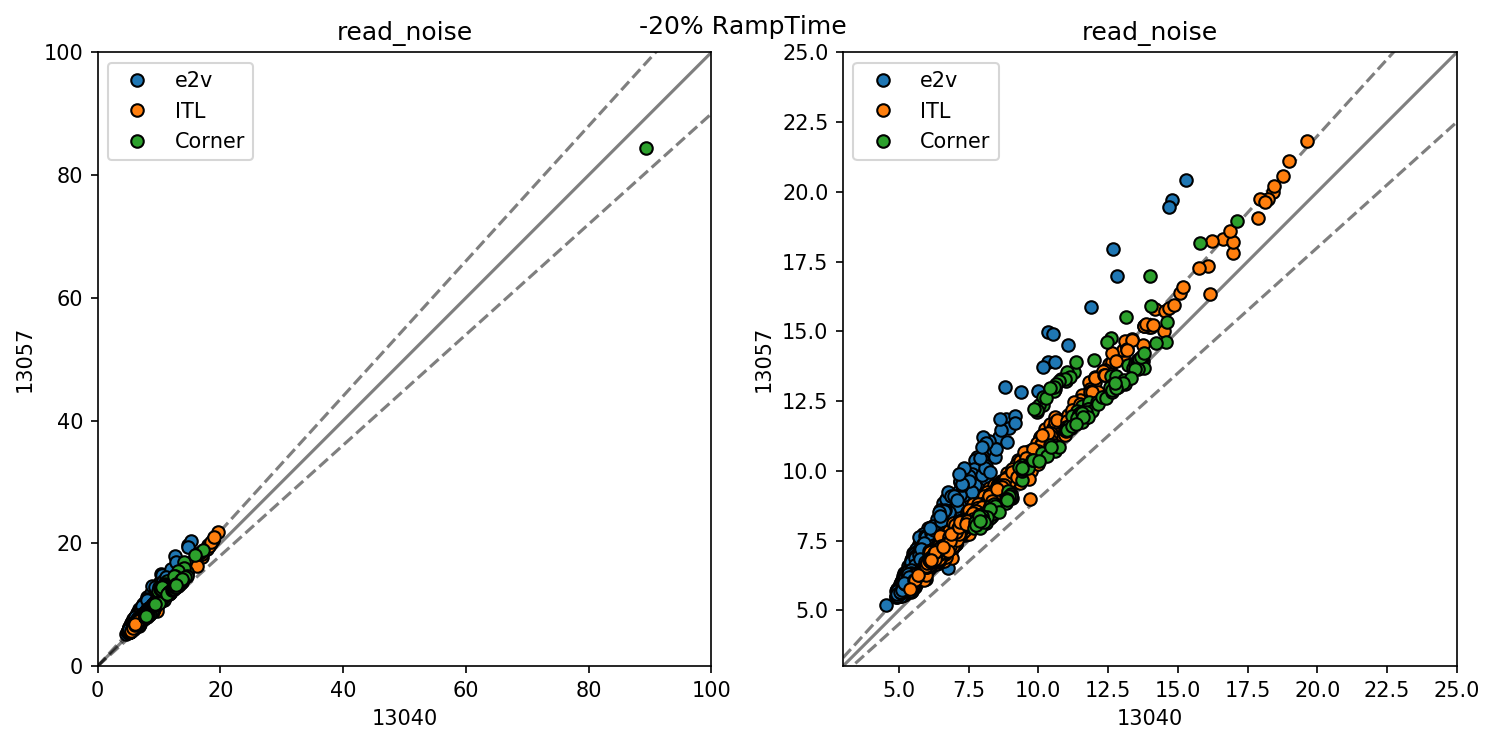

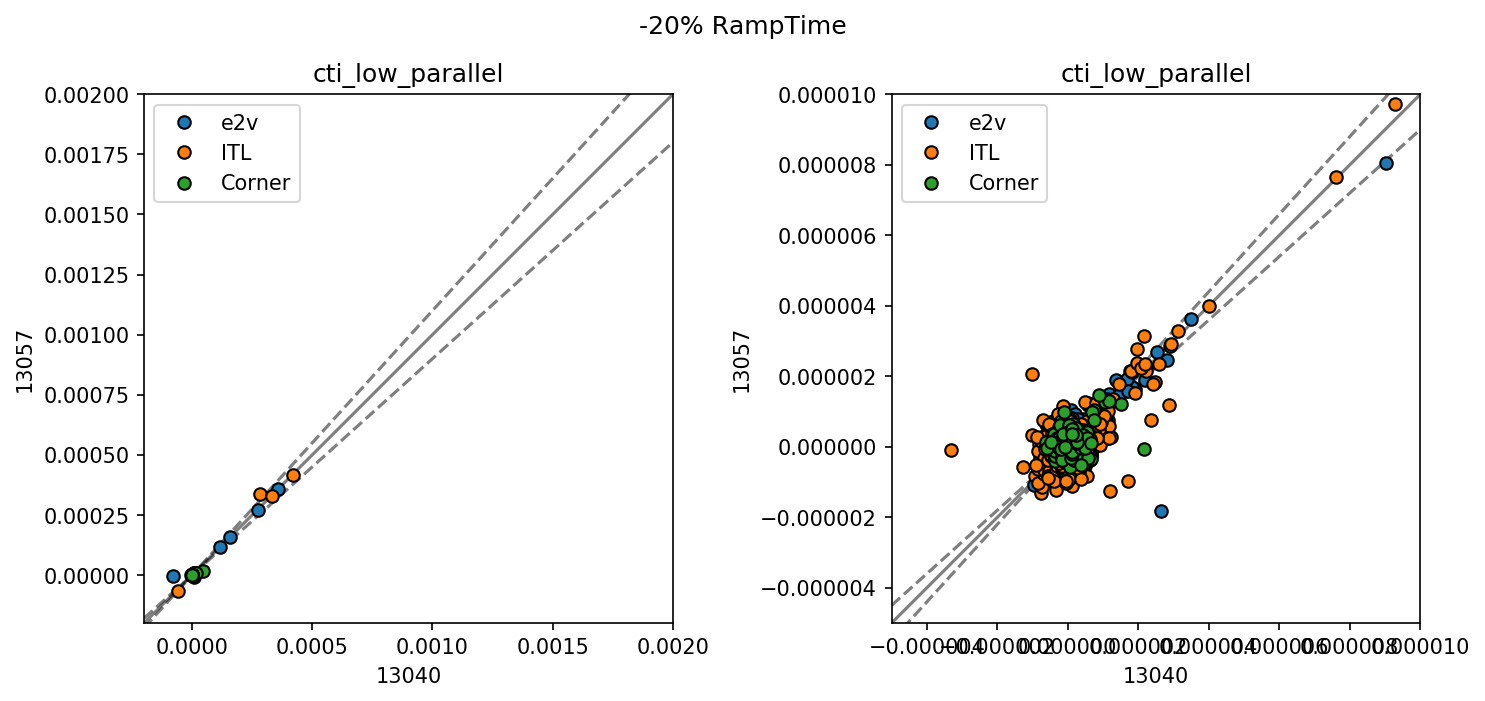

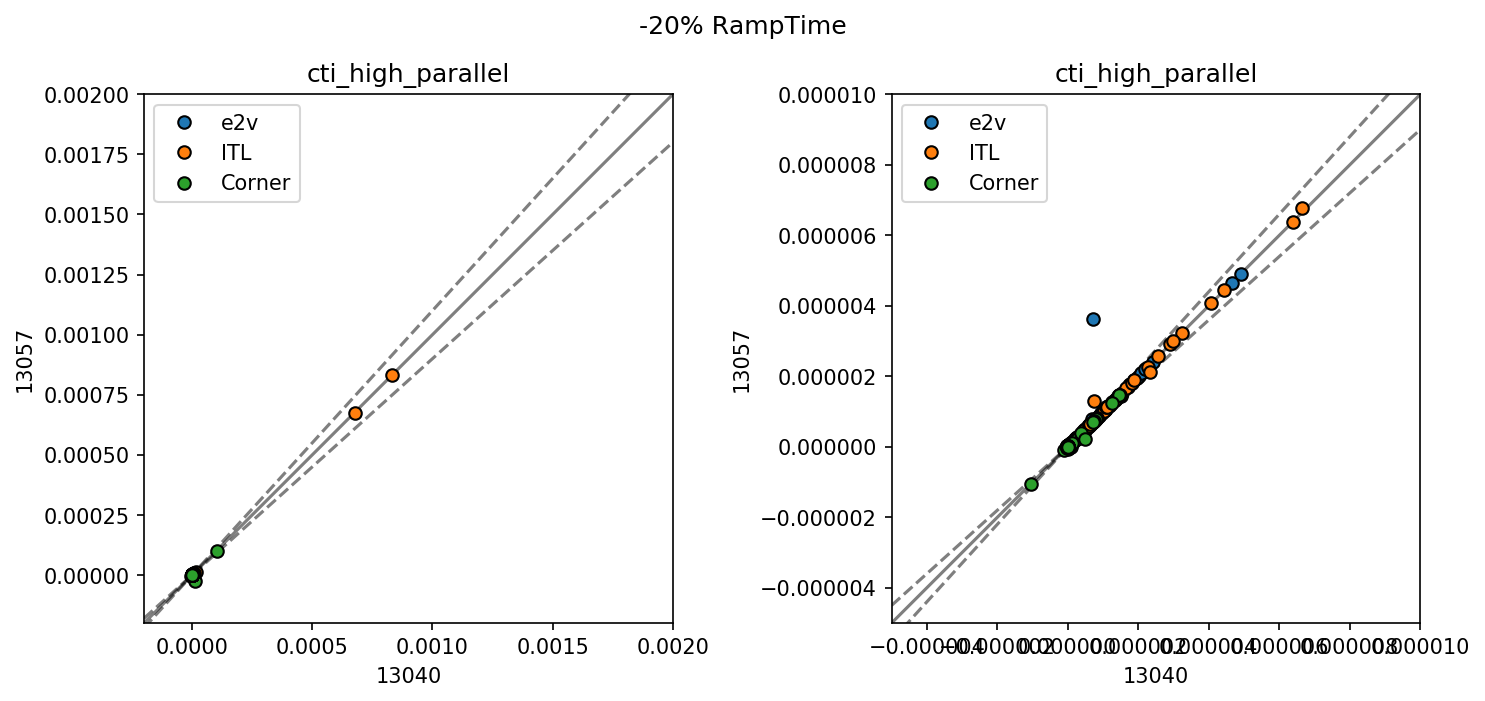

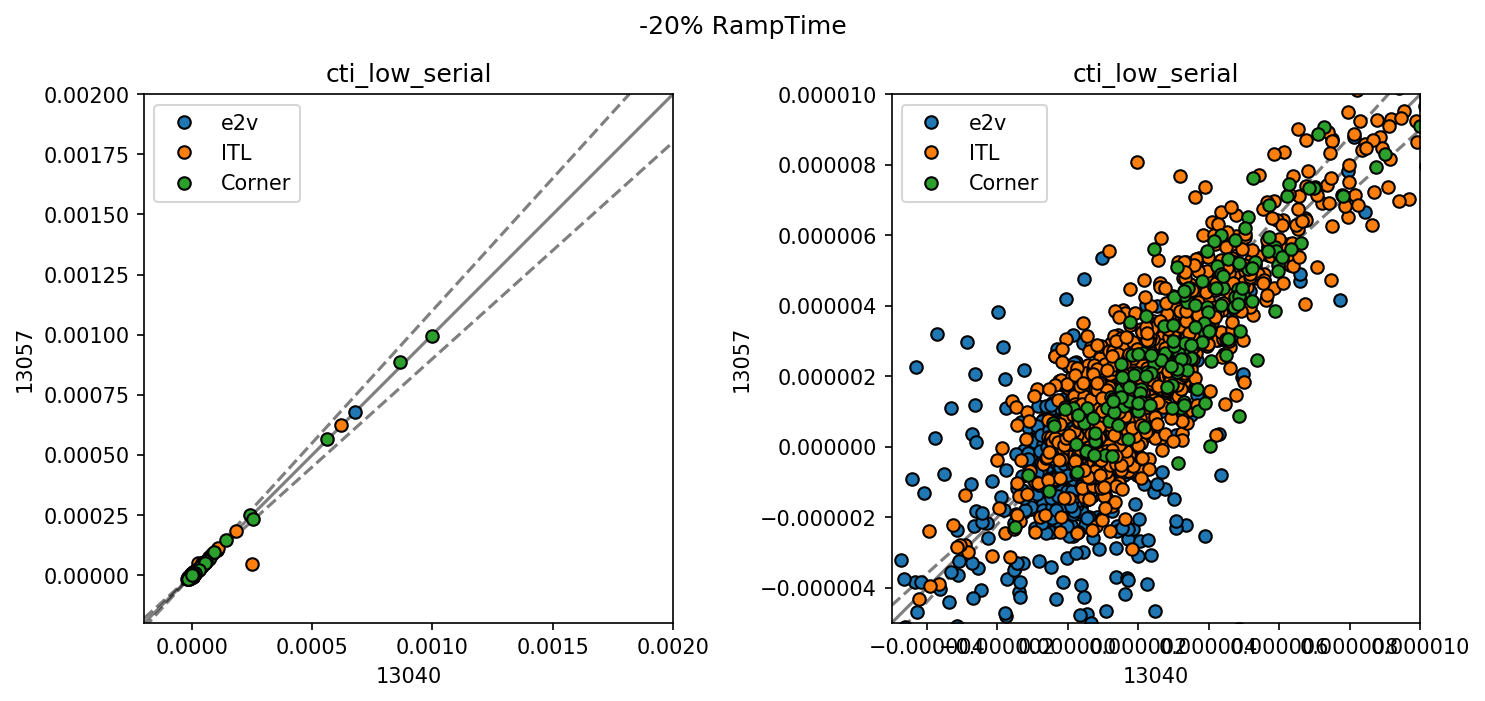

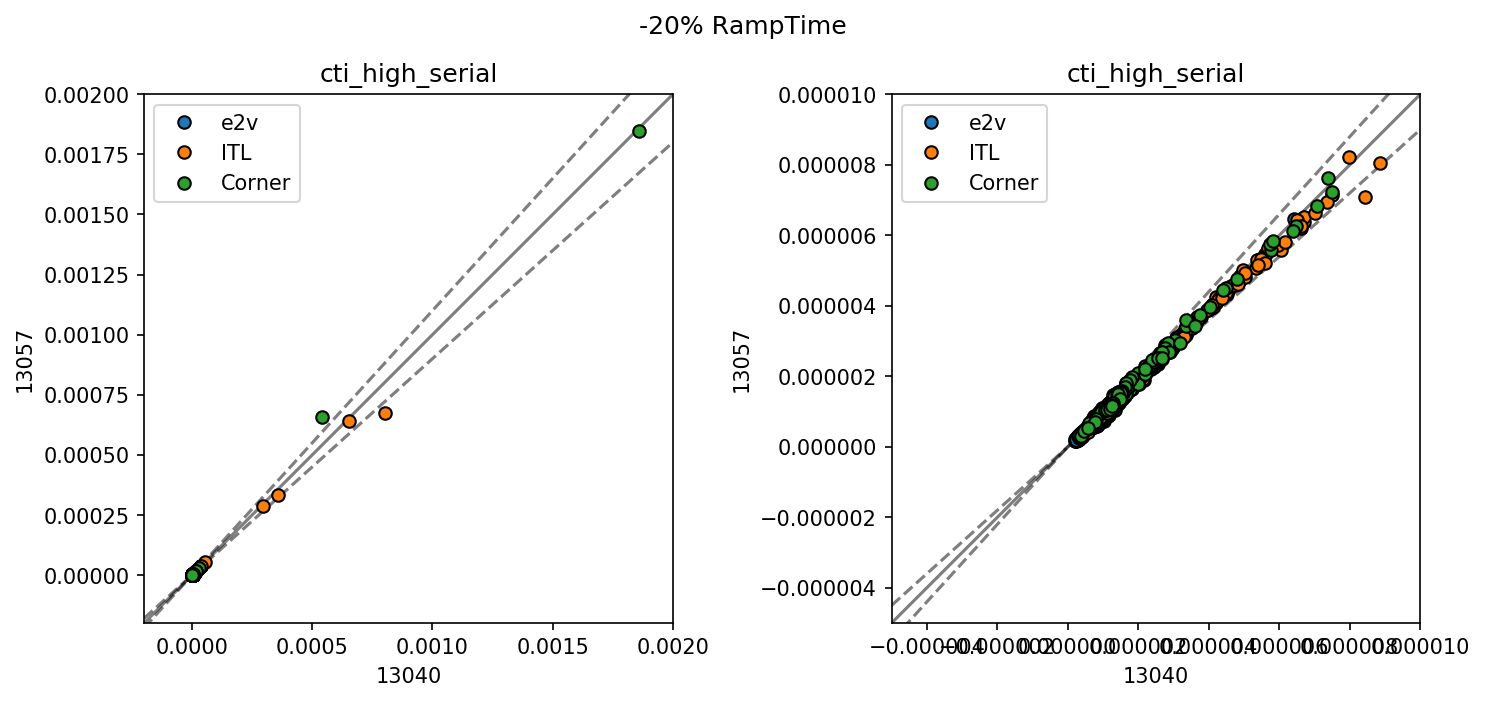

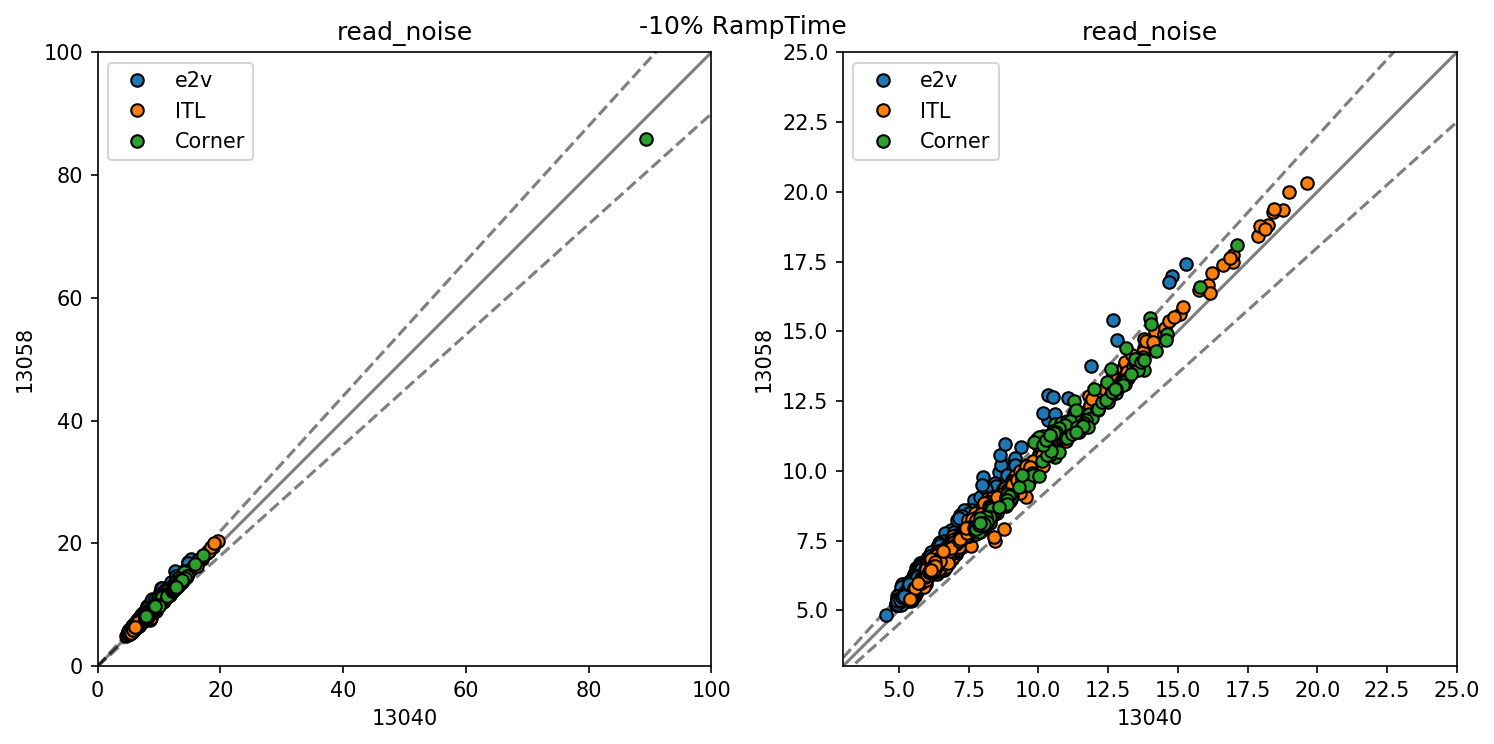

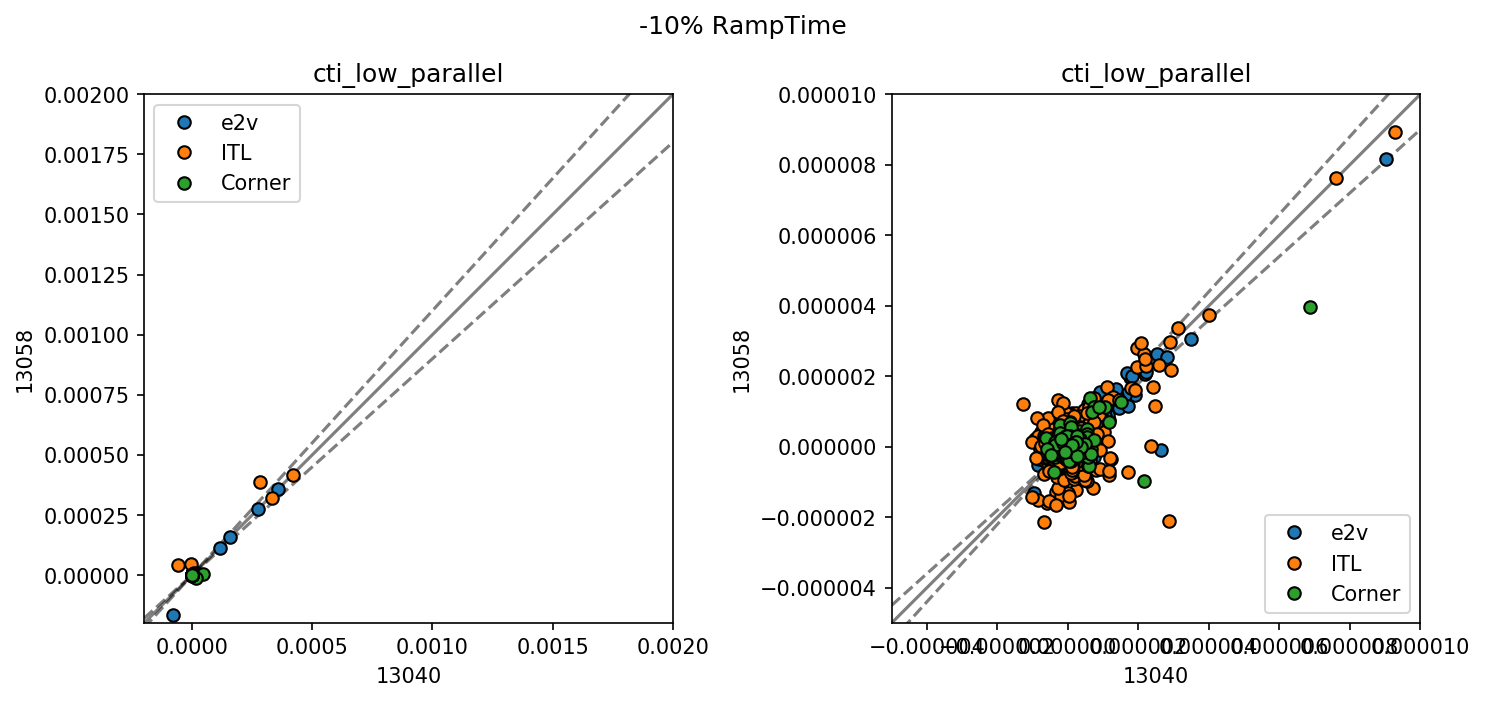

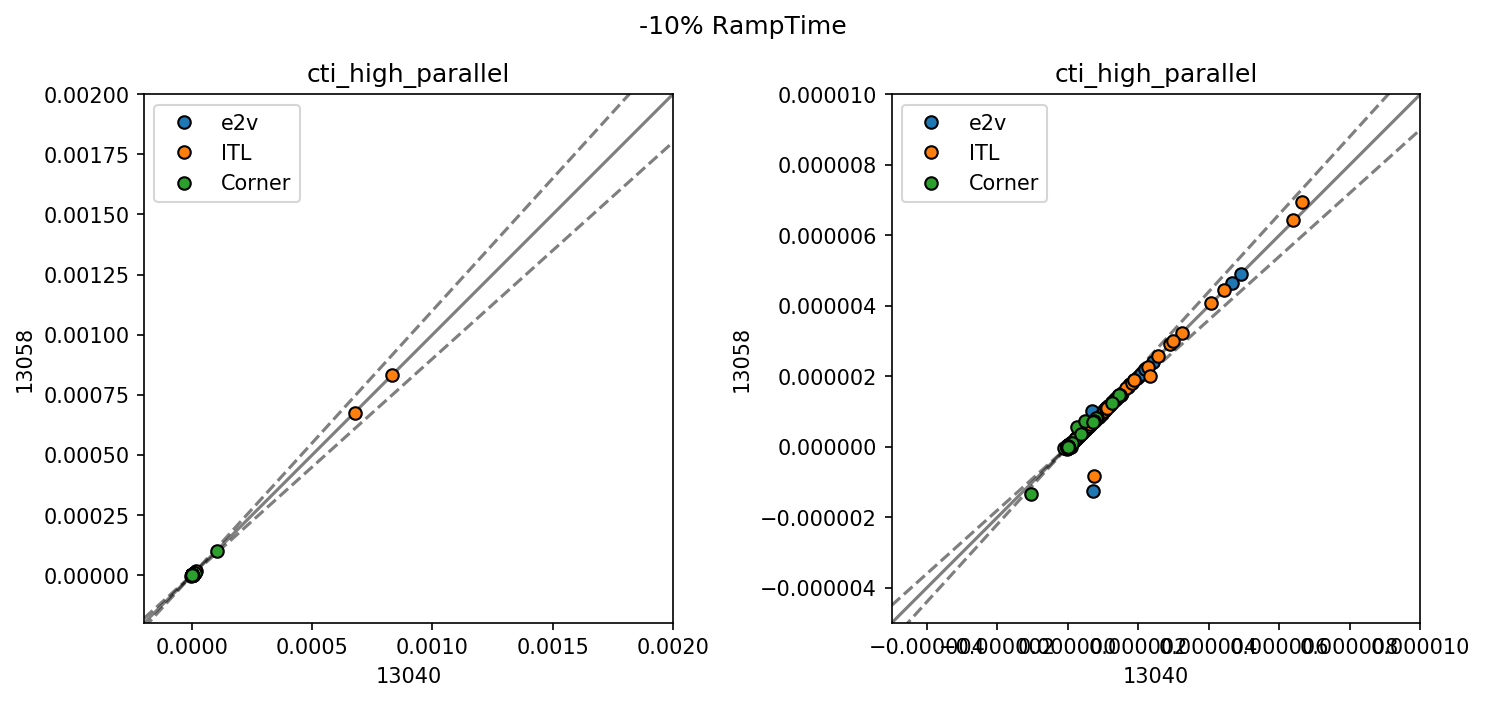

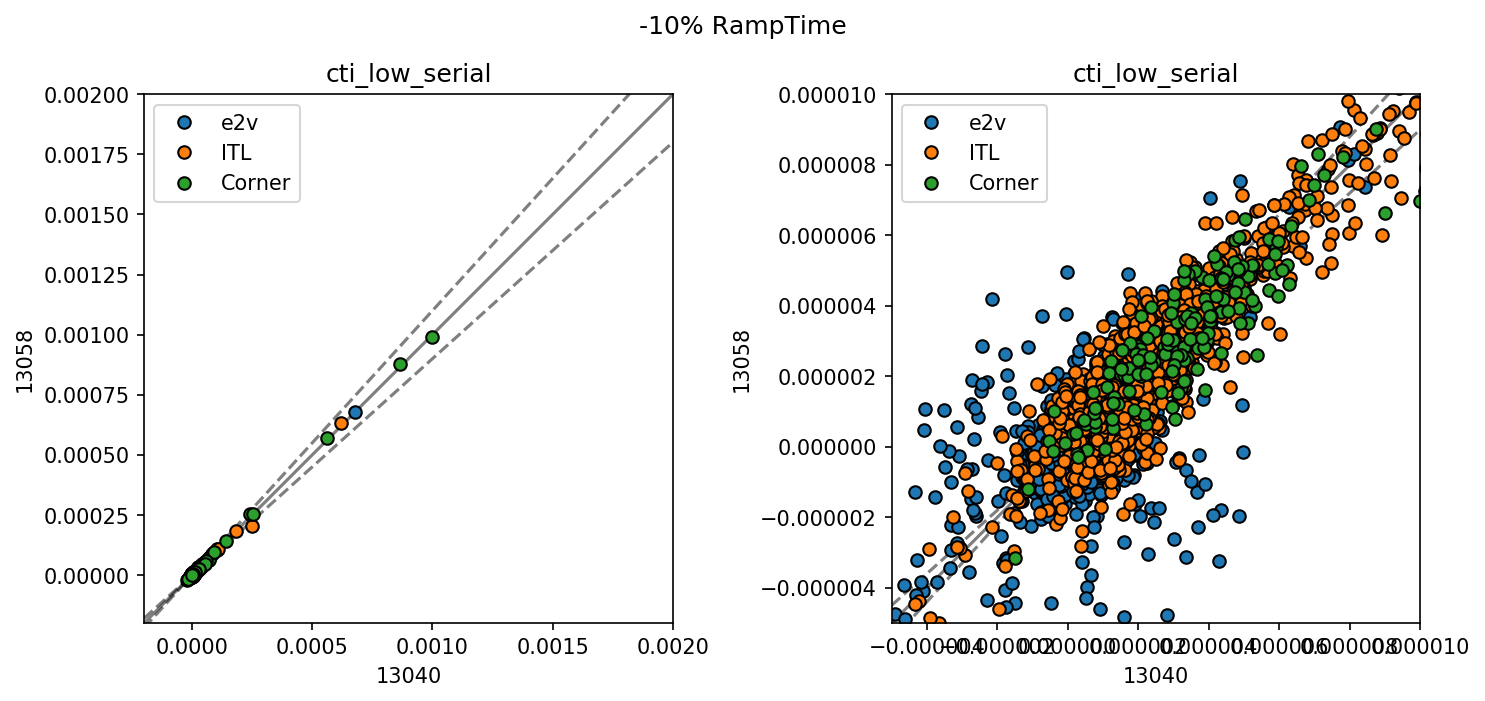

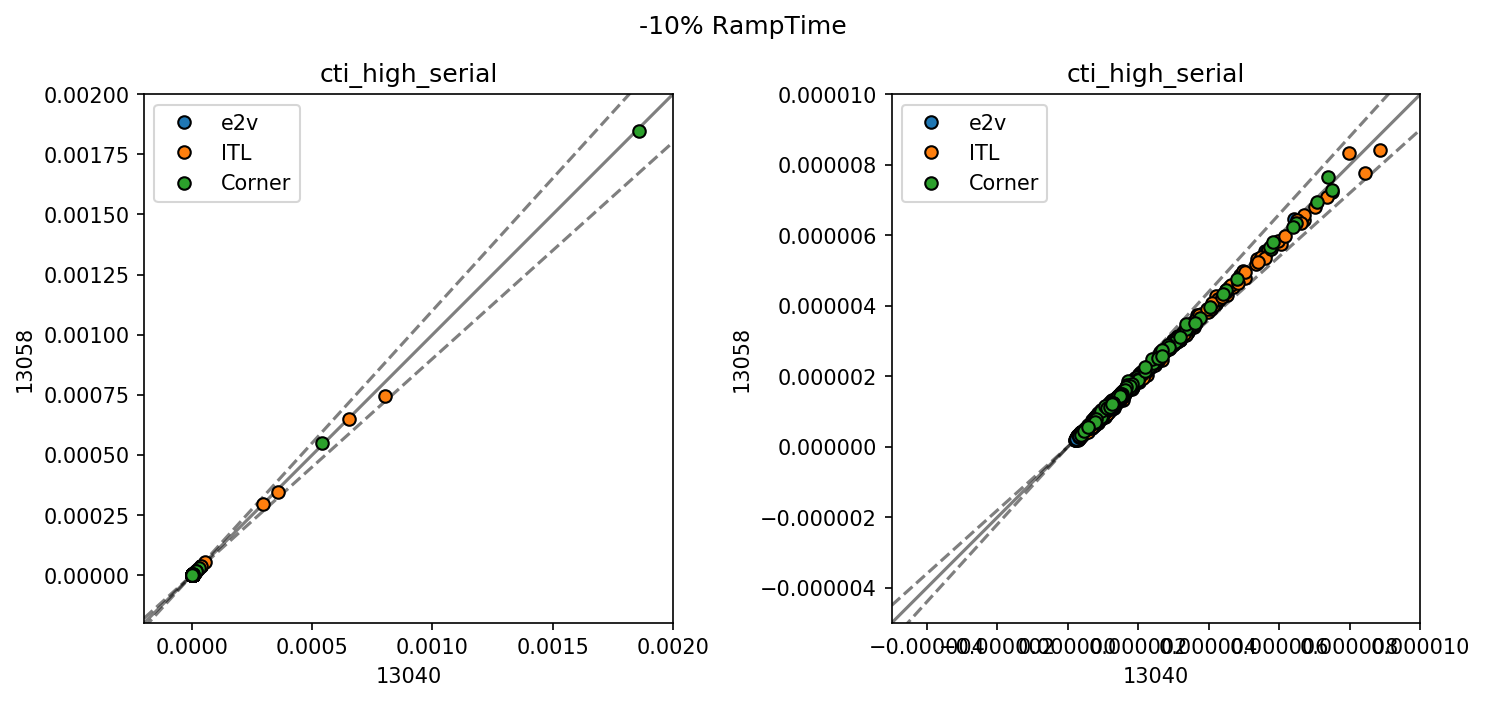

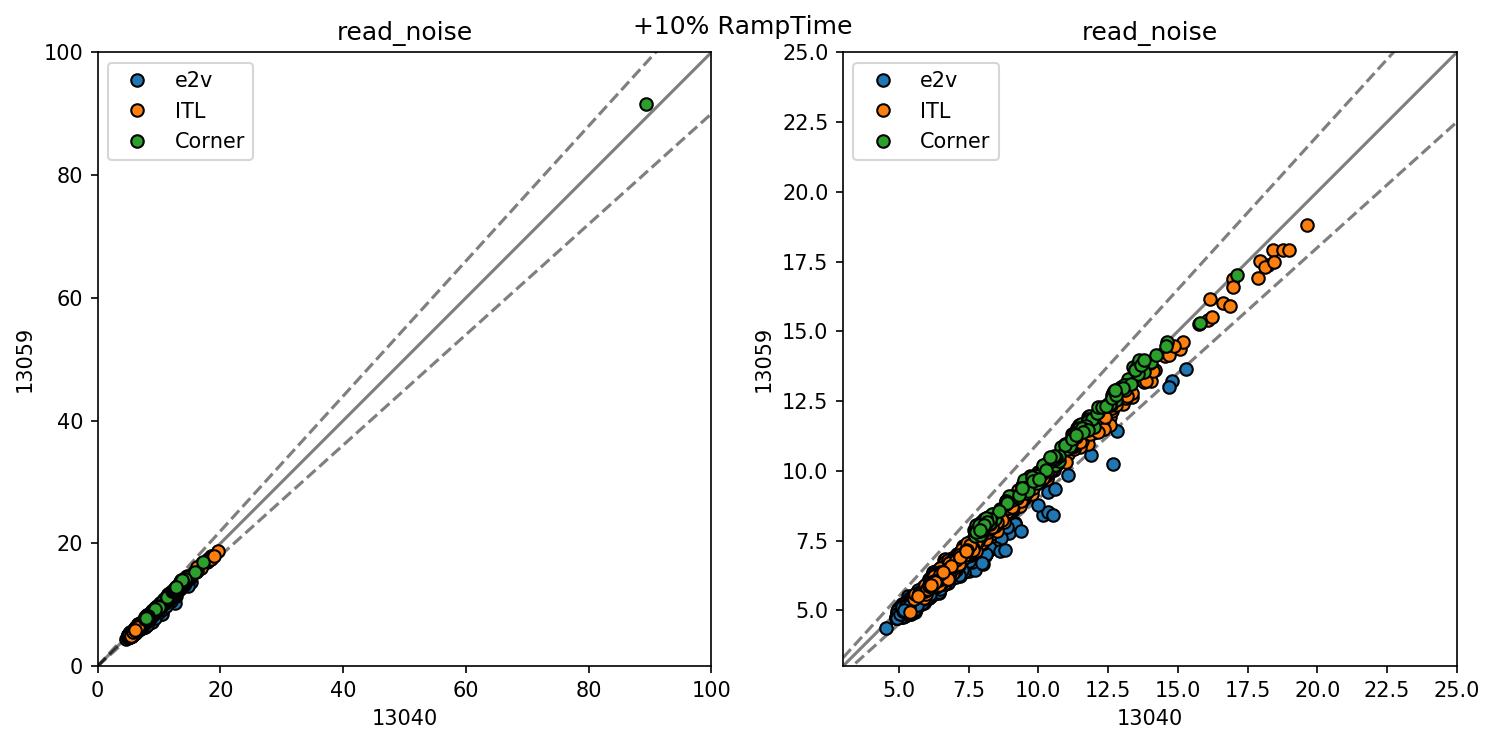

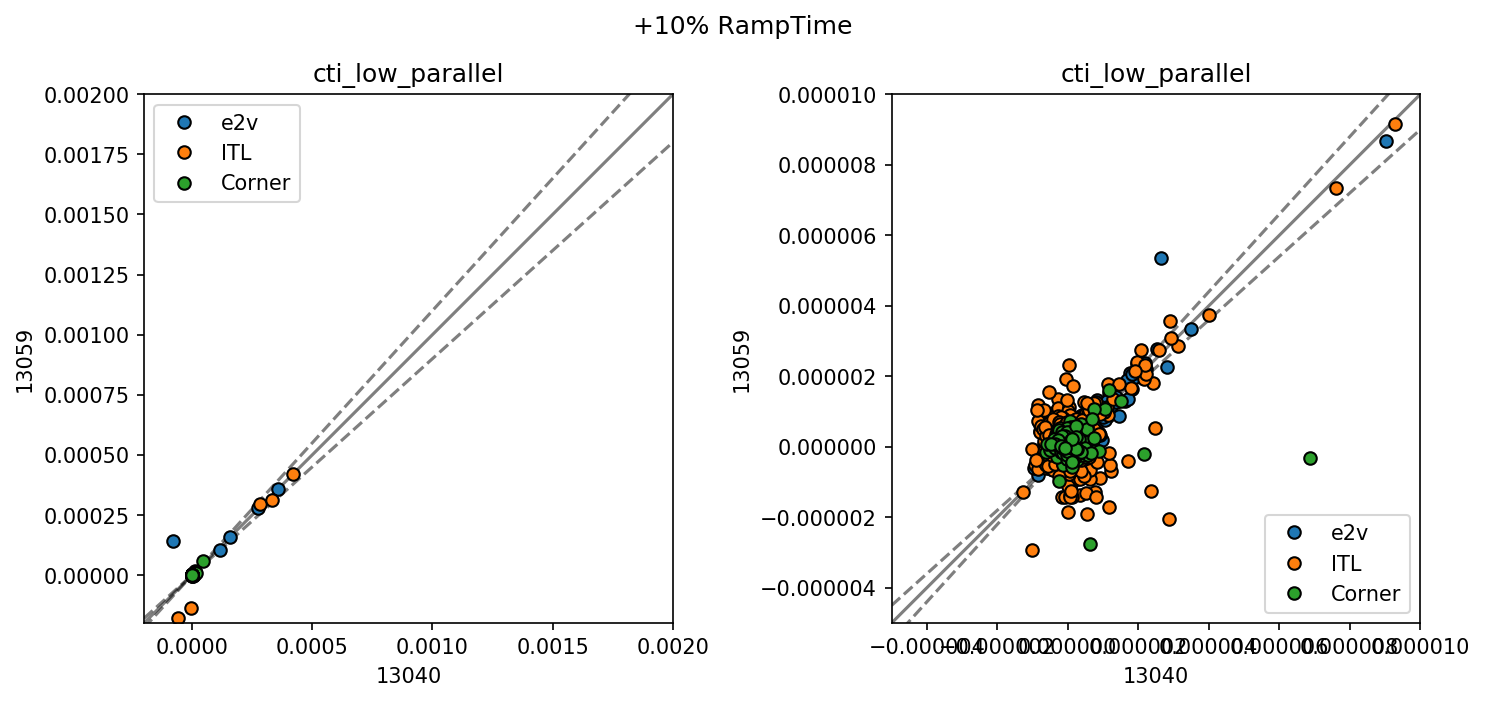

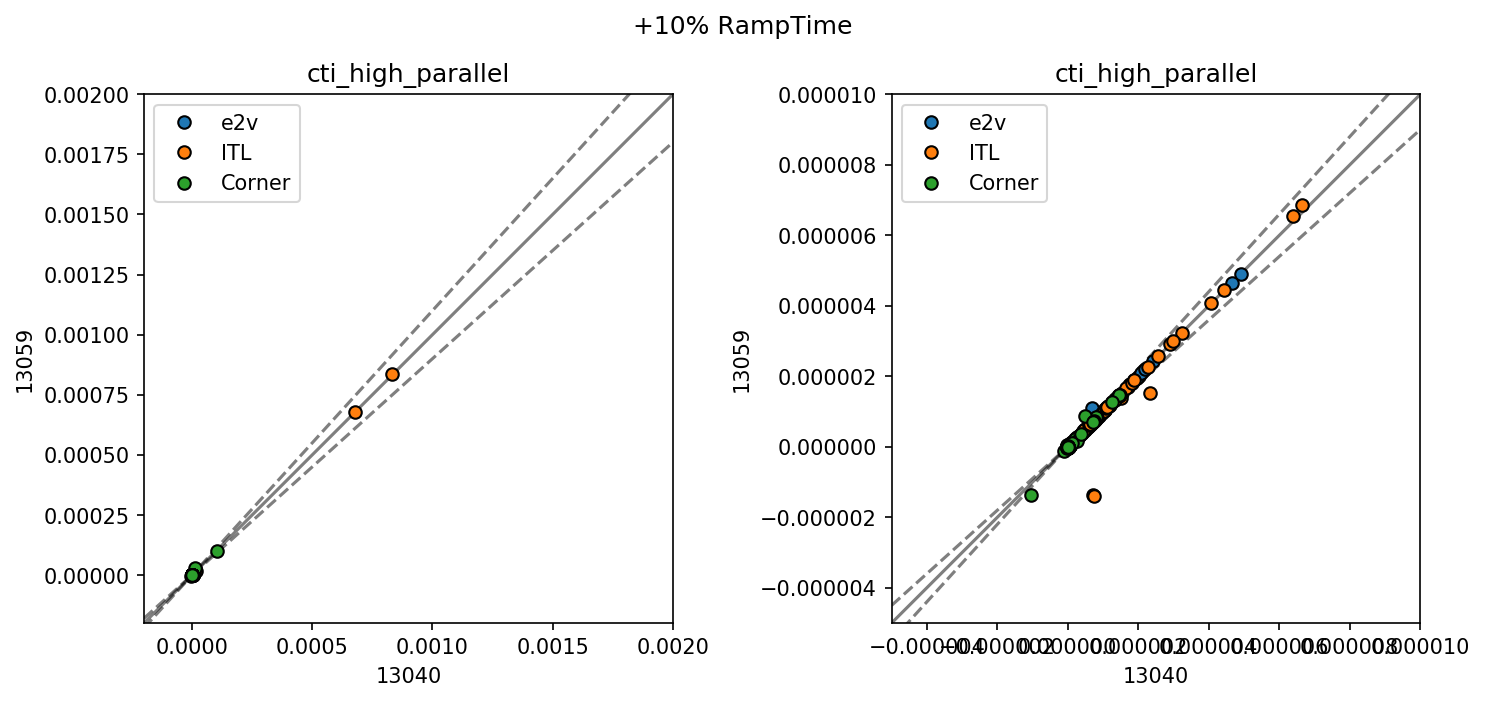

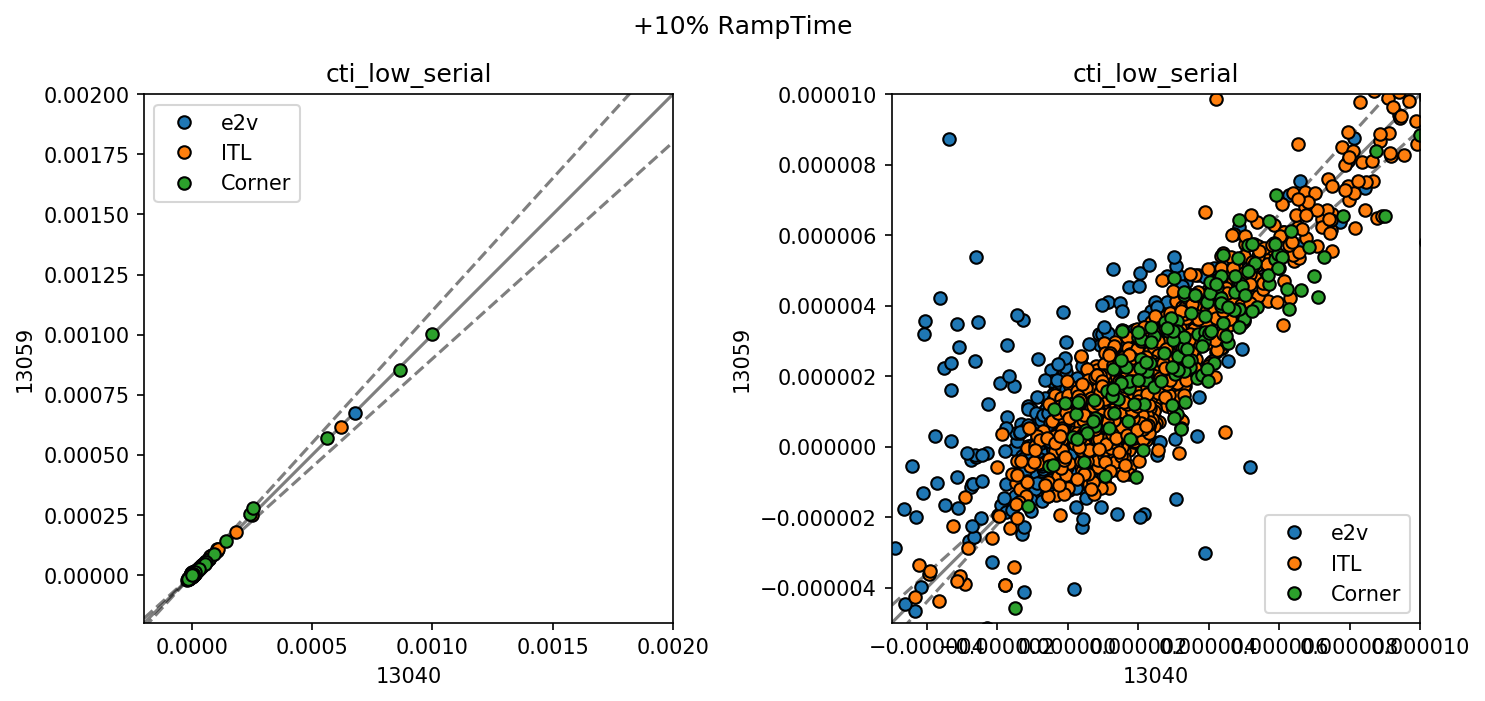

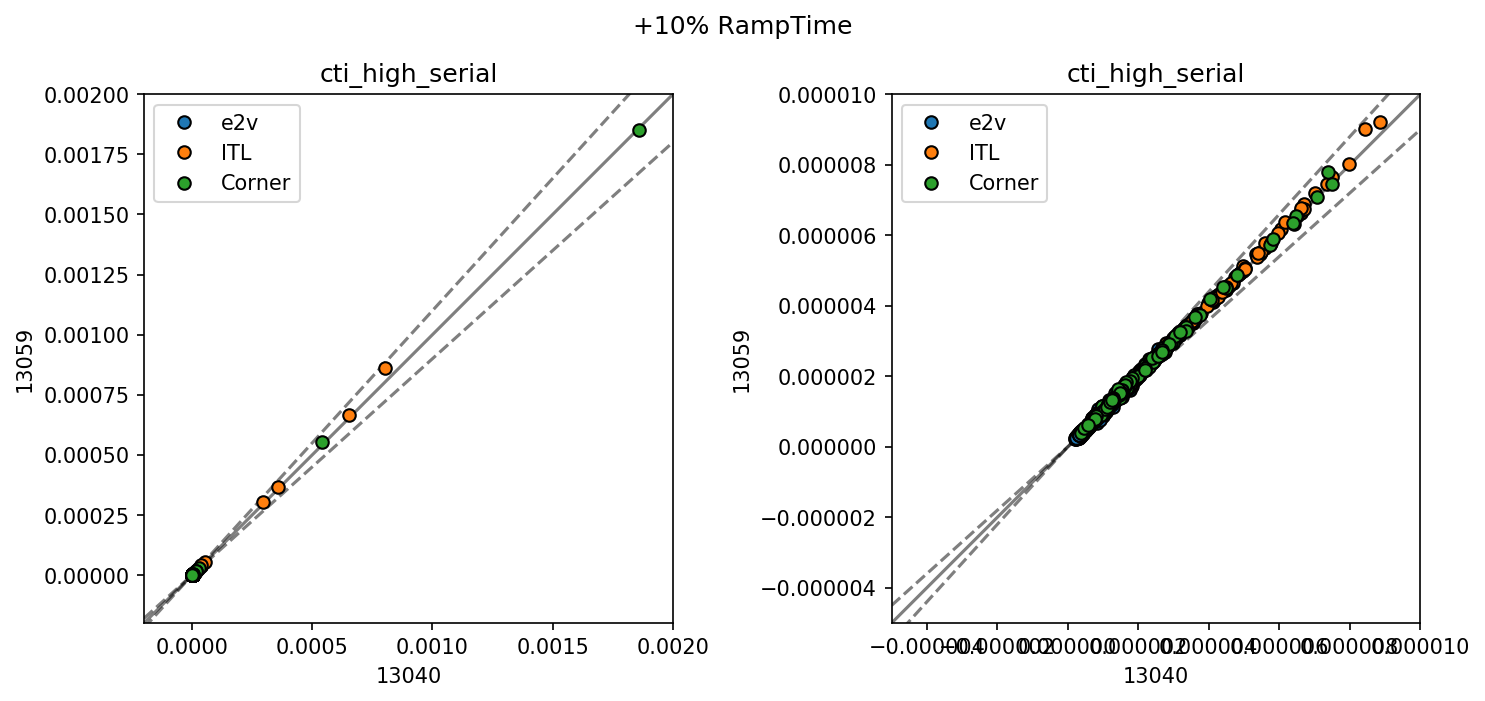

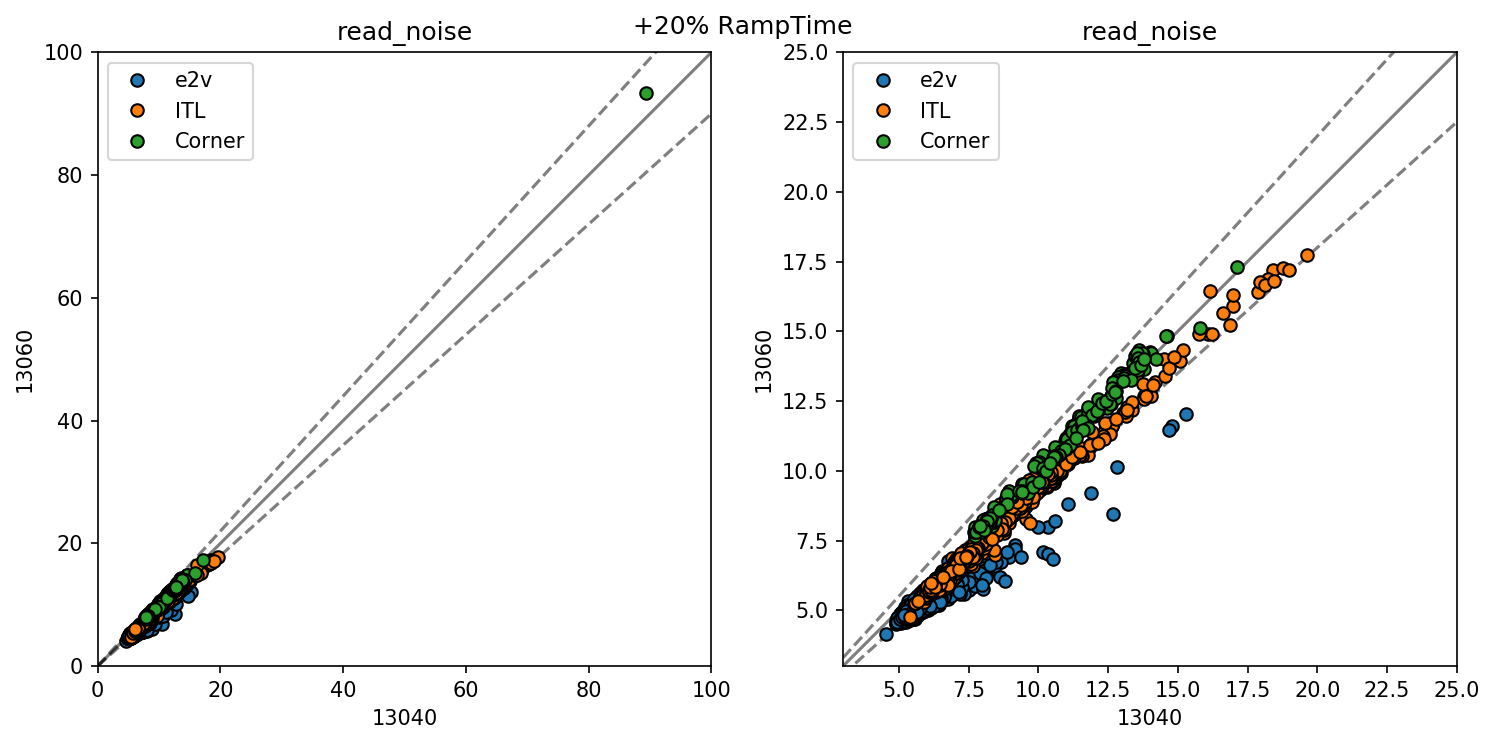

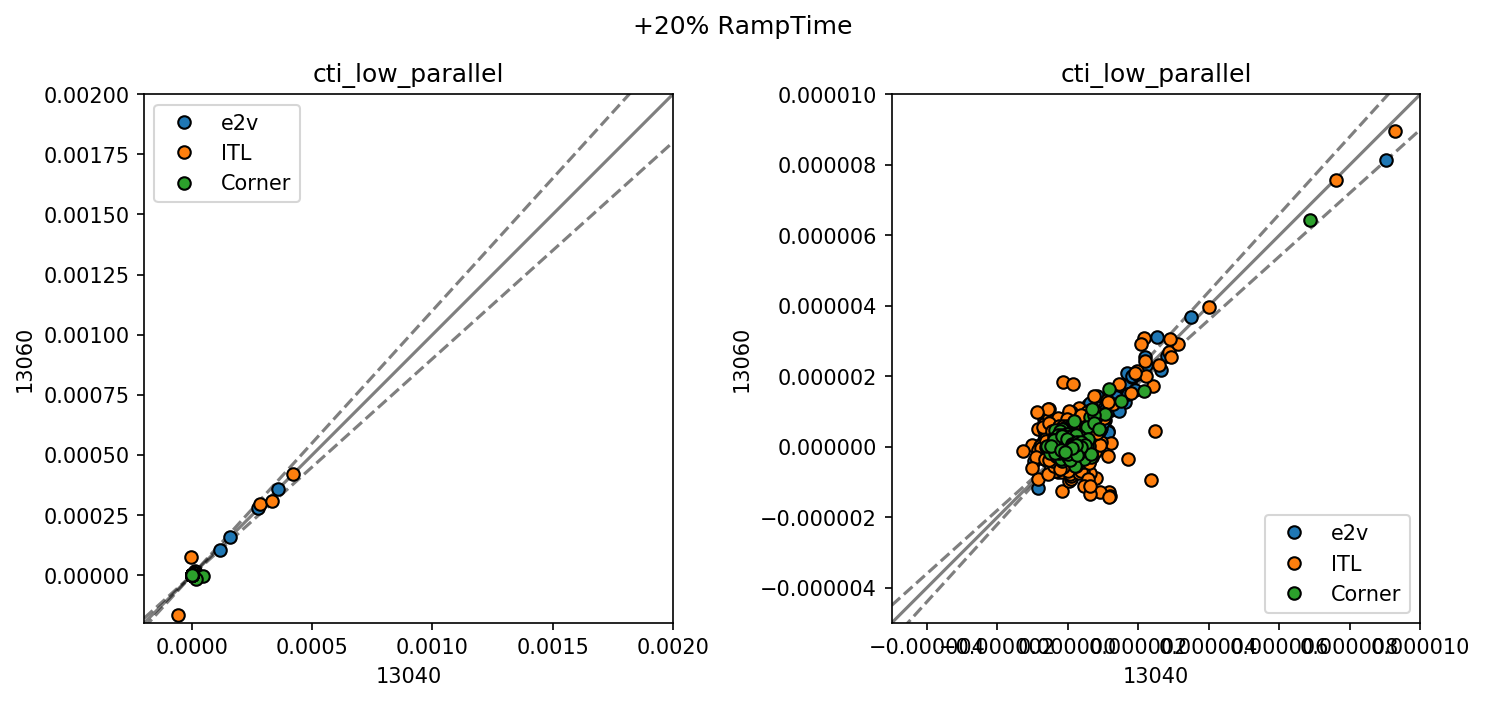

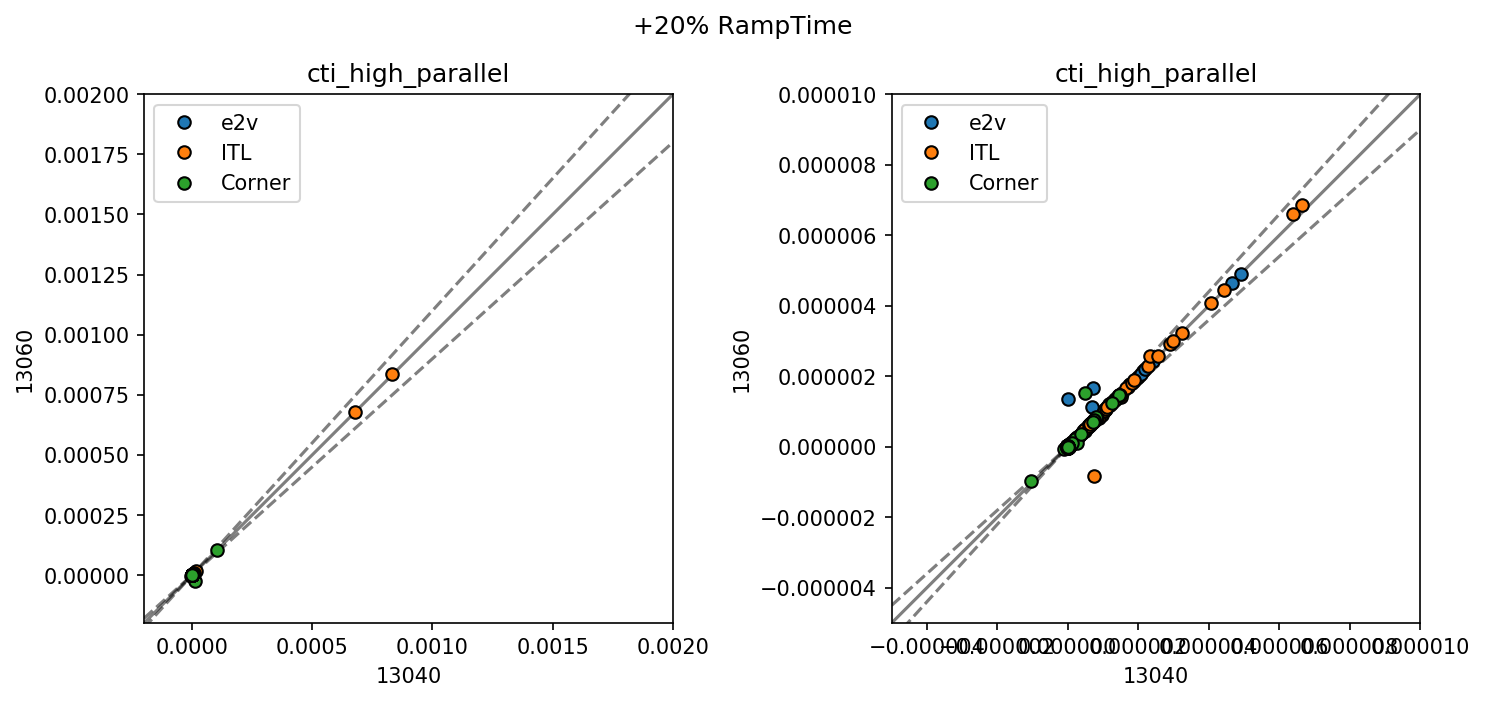

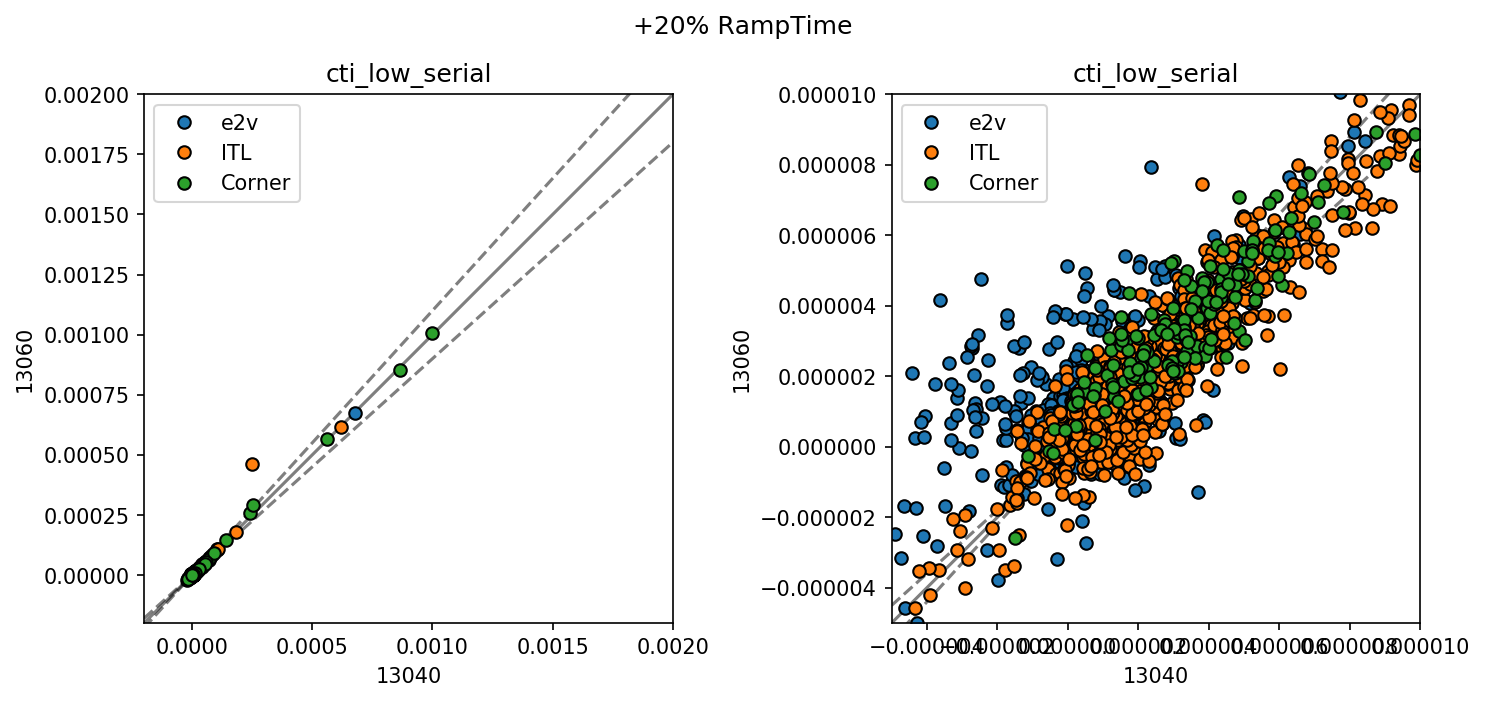

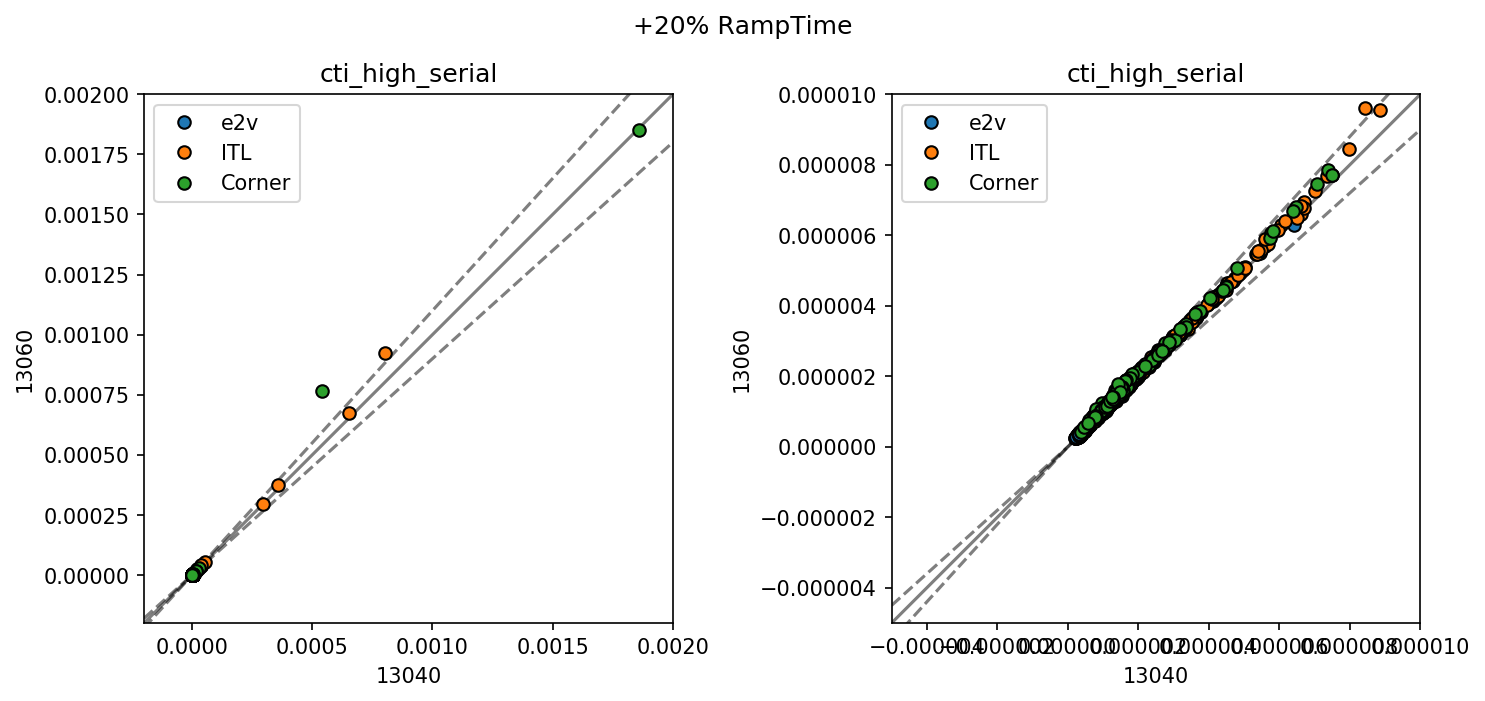

In [6]:
dev_list1, data1 = EO.get_tests(site_type='I&T-BOT', run=botrun1)
botresults1 = EO.get_all_results(data1)    
    
for botrun2, scale, title in [
    (13057, 1.231, "-20% RampTime" ),
    (13058, 1.104, "-10% RampTime"),
    (13059, 0.914, "+10% RampTime"),
    (13060, 0.8434, "+20% RampTime")
    ]:
    dev_list2, data2 = EO.get_tests(site_type='I&T-BOT', run=botrun2)
    botresults2 = EO.get_all_results(data2)
    for atest, lim, s in [
        ("read_noise", [ (0, 100), (3, 25) ], scale ),
        ("cti_low_parallel", [ (-2e-4, 2e-3), (-.5e-5, 1e-5) ], 1),
        ("cti_high_parallel", [ (-2e-4, 2e-3), (-.5e-5, 1e-5) ], 1),
        ("cti_low_serial", [ (-2e-4, 2e-3), (-.5e-5, 1e-5) ], 1),
        ("cti_high_serial", [ (-2e-4, 2e-3), (-.5e-5, 1e-5) ], 1) ]:

        makescatter( botrun1, botrun2, botresults1, botresults2, atest, lim, scale=s, err=False, suptitle=title )

# MaxADC study

picked the brightest exposure from a flat pair acquisition.

In [7]:
botrun =13073
dev_list1, data1 = EO.get_tests(site_type='I&T-BOT', run=botrun)
botresults1 = EO.get_all_results(data1)

import glob

measurements = {}
for flavor in raft_types:
    measurements[flavor] = []
    for abay in raft_types[flavor]:
        for asensor in botresults1["max_observed_signal"][abay]:            
            fh = fits.open(glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{botrun}/BOT_acq/v0/*/flat_empty_SDSSi_250000.0_flat0_153/*{abay}_{asensor}.fits")[0])
            measurements[flavor].extend( [ plane.data.max() for plane in fh[1:-2] ] )

The numbers here are the maximum number, and the ratio to 190k

e2v 197353 1.0387
ITL 191902 1.0100105263157895
Corner 202021 1.0632684210526315


[]

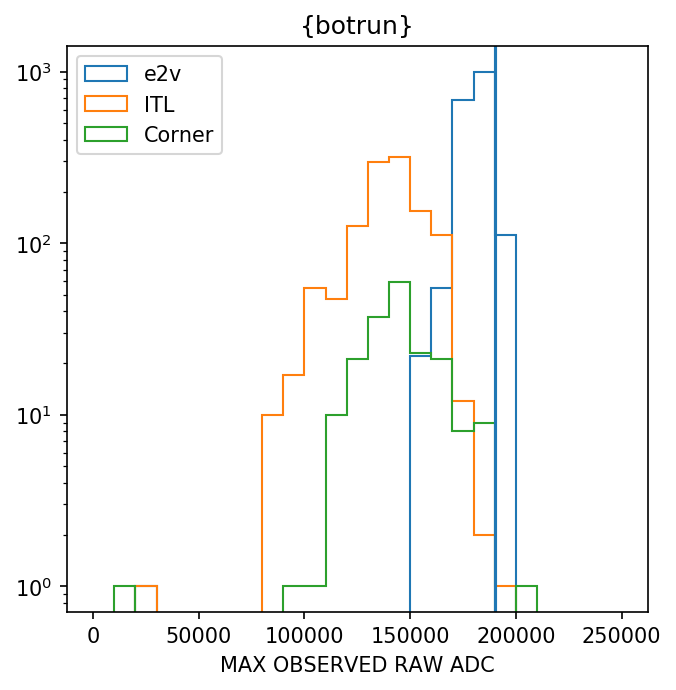

In [8]:
fig, axs = pylab.subplots(1,1,figsize=(5,5),dpi=150,facecolor="white")


for flavor in raft_types:
    pylab.hist(measurements[flavor], label=flavor, histtype="step", range=(0,250e3),bins=25)
    print(flavor, max(measurements[flavor]), max(measurements[flavor])/190e3)

pylab.axvline(190e3)
pylab.xlabel("MAX OBSERVED RAW ADC")
pylab.title("{botrun}")
pylab.legend()
pylab.semilogy()

# Bias variability study

In [9]:
import pickle
import warnings
import traceback
warnings.simplefilter(action='ignore', category=FutureWarning)

Text(0.5, 0.98, '\nbias stability, p+s overscan corrected\n200x200 pixel region covering the readout corner\n')

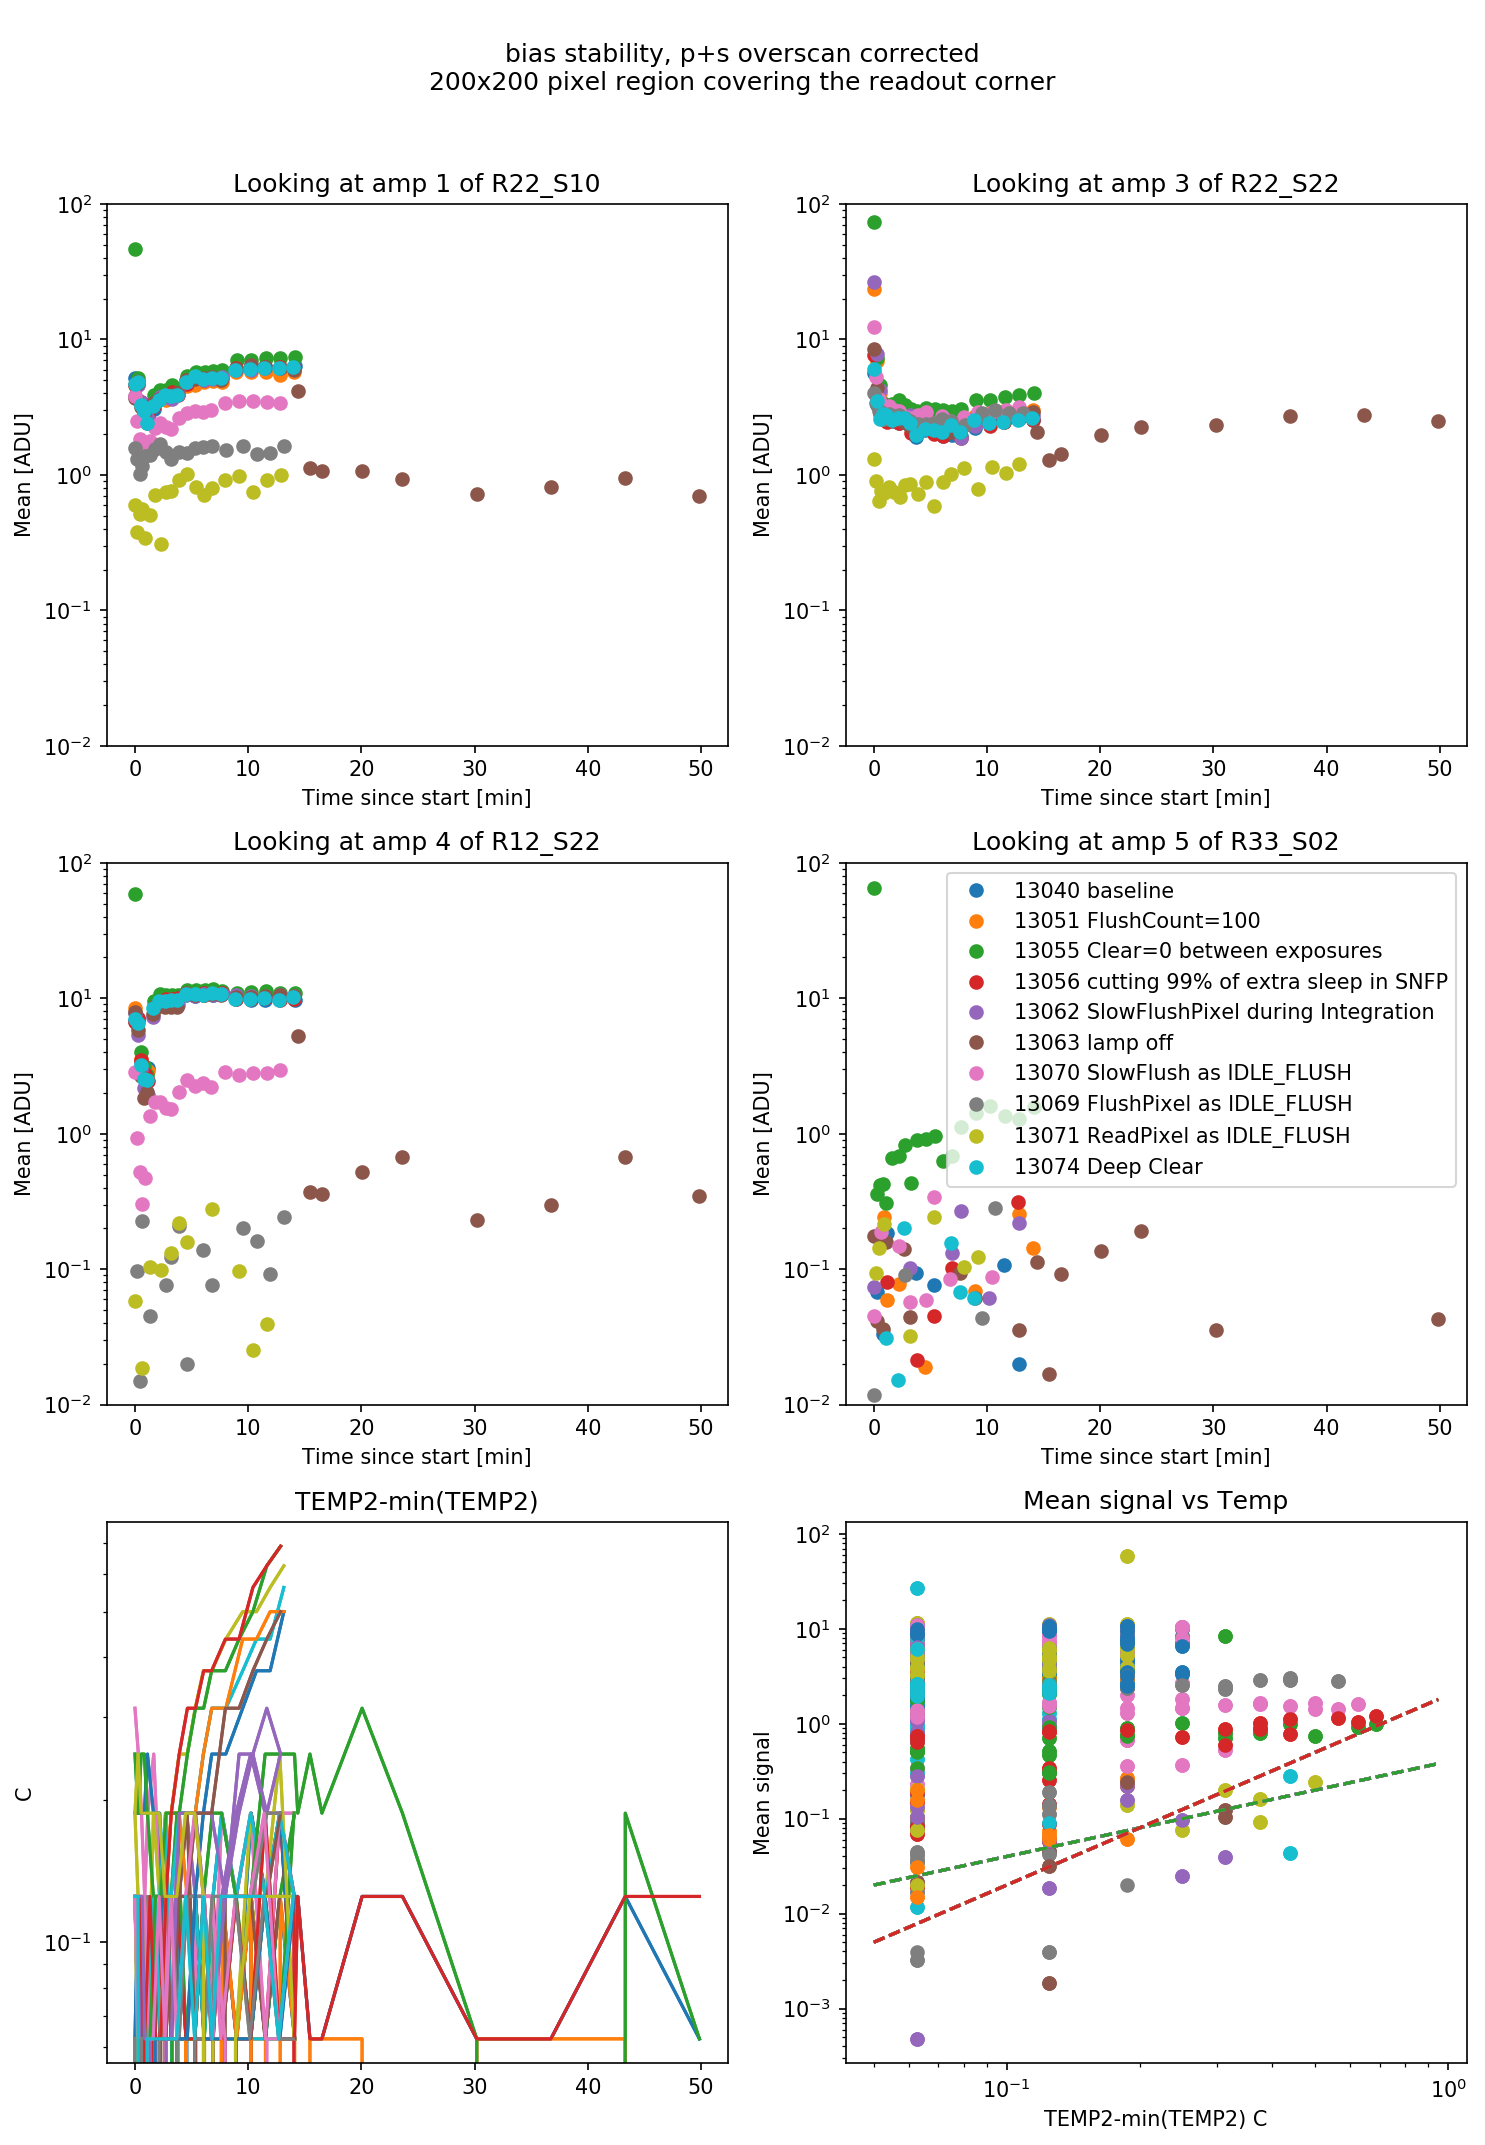

In [10]:
fig, axs = pylab.subplots(3,2,figsize=(10,15),dpi=150,facecolor="white")

targets = [
            (1,"R22_S10"),
            (3,"R22_S22"),
            (4,"R12_S22"),
            (5,"R33_S02")
         ]

tempkey="TEMP2"
notyet = True
for ax, (amp, raft) in zip(axs.flatten(), [
            *targets,
            (None,None),
            (None,None)
        ]):
    for run, description in [
            (13040, "baseline"),
            (13051, "FlushCount=100"),
            (13055, "Clear=0 between exposures"),
#            (13053, "cutting 50% of extra sleep in SNFP"),
#            (13054, "cutting 90% of extra sleep in SNFP"),
            (13056, "cutting 99% of extra sleep in SNFP"),
            (13062, "SlowFlushPixel during Integration"),
            (13063, "lamp off"),
            (13070, "SlowFlush as IDLE_FLUSH"),        
            (13069, "FlushPixel as IDLE_FLUSH"),
            (13071, "ReadPixel as IDLE_FLUSH"),
            (13074, "Deep Clear")
        ]:
        
        if amp!=None:
            with open(glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{run}/bias_frame_BOT/v0/*/{raft}_{run}_bias_frame_stats.pickle")[0], "rb") as f:
                data=pickle.load(f)
            cond = data["amp"]==amp
            ax.plot( (data[cond]["MJD"]-data[cond]["MJD"].min())*24*60, data[cond]["llc_mean"],
                    "o", label=f"{run} {description}" )

            ax.set_title(f"Looking at amp {amp} of {raft}")
            ax.set_xlabel("Time since start [min]")
            ax.set_ylabel("Mean [ADU]")
            ax.set_ylim(1e-2,1e2)
            ax.semilogy()
        
        else:
            ax=axs.flatten()[-2]
            for ampb, raft in targets:
                with open(glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{run}/bias_frame_BOT/v0/*/{raft}_{run}_bias_frame_stats.pickle")[0], "rb") as f:
                    data=pickle.load(f)            
                cond = data["amp"]==ampb
                ax.plot((data[cond]["MJD"]-data[cond]["MJD"].min())*24*60, data[cond][tempkey]-data[cond][tempkey].min(),
                        label=f"{run} {description}")
            ax.set_title(f"{tempkey}-min({tempkey})")
            ax.semilogy()
            ax.set_ylabel("C")

            if notyet:
                notyet=False
                continue
            ax=axs.flatten()[-1]
            for ampb, raftb in targets:
                with open(glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{run}/bias_frame_BOT/v0/*/{raftb}_{run}_bias_frame_stats.pickle")[0], "rb") as f:
                    data=pickle.load(f)            
                cond = data["amp"]==ampb
                ax.plot(data[cond][tempkey]-data[cond][tempkey].min(),data[cond]["llc_mean"],
                        "o")
            x=numpy.arange(5e-2,1e0,0.1)
            for i in [1,2]:
                y=0.8e-1*(x/2e-1)**i
                ax.plot(x,y,"--",label=f"x^{i}")
            ax.set_title("Mean signal vs Temp")
            ax.loglog()
            ax.set_xlabel(f"{tempkey}-min({tempkey}) C")
            ax.set_ylabel("Mean signal")

axs.flatten()[-3].legend()
pylab.tight_layout(rect=[0, 0.03, 1, 0.92])
pylab.suptitle(f"""
bias stability, p+s overscan corrected
200x200 pixel region covering the readout corner
""")

Text(0.5, 0.98, '\nbias stability, p+s overscan corrected\n200x200 pixel region covering the readout corner\n')

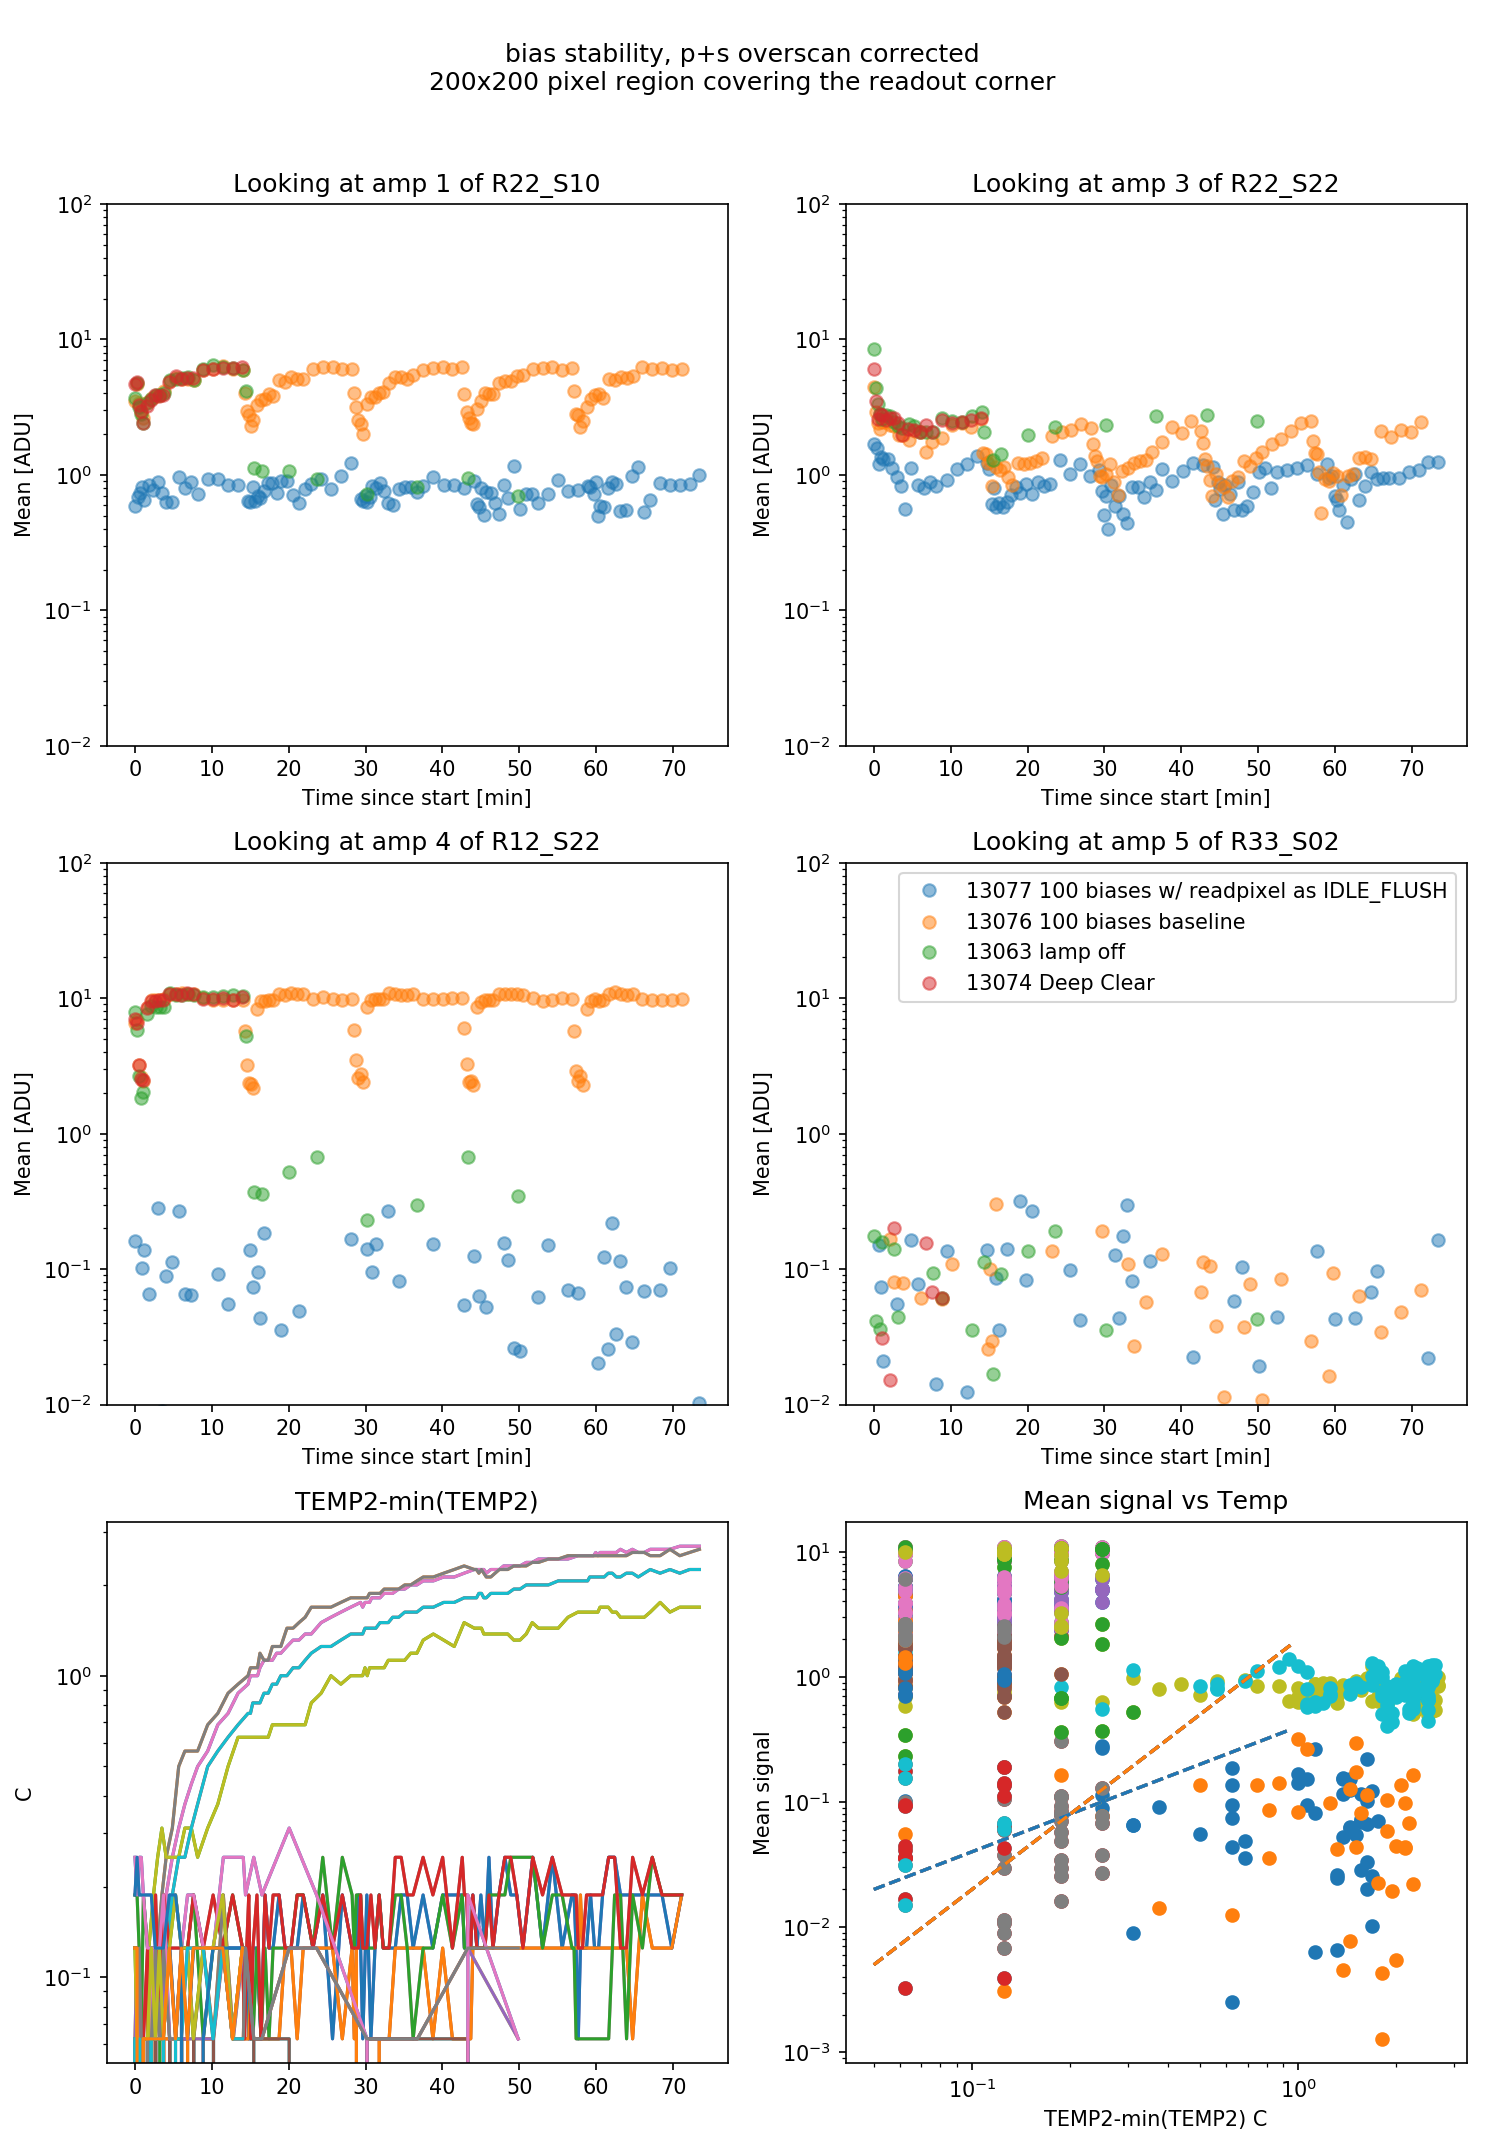

In [11]:
fig, axs = pylab.subplots(3,2,figsize=(10,15),dpi=150,facecolor="white")

targets = [
            (1,"R22_S10"),
            (3,"R22_S22"),
            (4,"R12_S22"),
            (5,"R33_S02")
         ]

tempkey="TEMP2"
notyet = True
for ax, (amp, raft) in zip(axs.flatten(), [
            *targets,
            (None,None),
            (None,None)
        ]):
    for run, description in [
            (13074, "Deep Clear"),        
            (13063, "lamp off"),
            (13076, "100 biases baseline"),
            (13077, "100 biases w/ readpixel as IDLE_FLUSH")        
        ][::-1]:
        
        if amp!=None:
            with open(glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{run}/bias_frame_BOT/v0/*/{raft}_{run}_bias_frame_stats.pickle")[0], "rb") as f:
                data=pickle.load(f)
            cond = data["amp"]==amp
            ax.plot( (data[cond]["MJD"]-data[cond]["MJD"].min())*24*60, data[cond]["llc_mean"],
                    "o", label=f"{run} {description}", alpha=0.5 )

            ax.set_title(f"Looking at amp {amp} of {raft}")
            ax.set_xlabel("Time since start [min]")
            ax.set_ylabel("Mean [ADU]")
            ax.set_ylim(1e-2,1e2)
            ax.semilogy()
        
        else:
            ax=axs.flatten()[-2]
            for ampb, raft in targets:
                with open(glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{run}/bias_frame_BOT/v0/*/{raft}_{run}_bias_frame_stats.pickle")[0], "rb") as f:
                    data=pickle.load(f)            
                cond = data["amp"]==ampb
                ax.plot((data[cond]["MJD"]-data[cond]["MJD"].min())*24*60, data[cond][tempkey]-data[cond][tempkey].min(),
                        label=f"{run} {description}")
            ax.set_title(f"{tempkey}-min({tempkey})")
            ax.semilogy()
            ax.set_ylabel("C")

            if notyet:
                notyet=False
                continue
            ax=axs.flatten()[-1]
            for ampb, raftb in targets:
                with open(glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{run}/bias_frame_BOT/v0/*/{raftb}_{run}_bias_frame_stats.pickle")[0], "rb") as f:
                    data=pickle.load(f)            
                cond = data["amp"]==ampb
                ax.plot(data[cond][tempkey]-data[cond][tempkey].min(),data[cond]["llc_mean"],
                        "o")
            x=numpy.arange(5e-2,1e0,0.1)
            for i in [1,2]:
                y=0.8e-1*(x/2e-1)**i
                ax.plot(x,y,"--",label=f"x^{i}")
            ax.set_title("Mean signal vs Temp")
            ax.loglog()
            ax.set_xlabel(f"{tempkey}-min({tempkey}) C")
            ax.set_ylabel("Mean signal")

axs.flatten()[-3].legend()
pylab.tight_layout(rect=[0, 0.03, 1, 0.92])
pylab.suptitle(f"""
bias stability, p+s overscan corrected
200x200 pixel region covering the readout corner
""")